# Week 4 - Counting Words & Phrases

This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words, simple and parsed phrases and explore the statistical properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the correlation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora. 

Then we shift to focus not simply on the *ideas* in a corpus, but also extracting precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases.

We will be introducing spaCy as a package for Computational Linguistics, and also walk you through how to use the Davies Corpora. 

While we wish to avoid using NLTK for heavy corpus analysis, some of its smaller functions can still be useful.

Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud_2020 #pip install git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

# Retrieving exemplary corpora

To get started we will need some examples. Let's start by downloading one of the corpuses from the Davies set purchased for this class and developed by a computational linguist at Brigham Young University. We can get a list of works available from the [corpora here](https://www.english-corpora.org/).

In this notebook, I will be accessing the data locally - you also have access to this data through the Dropbox download link. The same code can be modified slighlty to access the rest of the corpora on RCC. 
There is a notebook describing this process in the same repository, as well as in the same directory on RCC.

In [27]:
corpus_name = "/Users/bhargavvader/Downloads/Movies"
# corpus_name = "Movies"

This method extracts the text from the zip files and stroes the raw data.

In [31]:
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        # check if the file name contains corpus_style'
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            # xfile is just the file name in the archive/zip,
            for file in zfile.namelist():
                texts_raw[xfile] = []
                with zfile.open(file) as f: #f is the opened file object
                    for line in f:
                        texts_raw[xfile].append(line)
    return texts_raw

In [7]:
# corpus_name = "/User/tianyi/Movies" 
# corpus_name = "/User/tianyi/Movies/" #corpus_name + "/"
# file = "text_17" #suppose

# corpus_name = "/User/tianyi/Movies/text_17" #corpus_name + "/" + file

#absolute directory, from root directory 
#relative directory <- determined on where you are right now. your current directory
# text_raw = {
# "movie_1.txt": ["today is a sunny day", "tomorrow is a rainy day"],
# "movie_2.txt": ["adfasdfasdfads", "adfsadfasdf"],
# "movie_3.txt": []}
#initializing an array, empty
# arr = []
# tianyi/movies/
# [movie1.txt, movie2.txt]
# movit1.txt 
# Tianyi/Movies
# |___ text_1.zip
#    |_ movie1.txt
#       line 1: today is a good day
#       line 2: tomorrow is another good day
#    |_ movie2.txt
#
# |___ pdf_2.zip
#    |_ movie2.txt
#    |_ movie3.txt
#
#
#
#
#
#
#
#
arr = [4, 5, 6, 7, 8, 9, 10]
print(arr[0:3])

[4, 5, 6]


In [32]:
movie_raw = loadcorpus(corpus_name)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/bhargavvader/Downloads/Movies/'

In [29]:
movie_raw['11.txt'][0:3]

NameError: name 'movie_raw' is not defined

It seems messy, but nothing we can't clean. This basic method replaces some of the issues with the formatting, and prints the errors if any for debugging. Let us clean one of the raw text files.

We ignore the non-unicode data for convenience for now.

In [5]:
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

In [7]:
clean_11 = clean_raw_text(movie_raw['11.txt'])

In [8]:
clean_11[1]

'@@216680 Hey , I\'m talking to you Give me 600 dollars You wish ! That\'s all we\'ve left And you still go to gamble Shut up I earn the money Even that you can\'t take it for gamble Shut up What\'re you doing ? Bastard , I\'m gon na beat you You gambling pig , I\'ll beat the shit out of you You bitch I\'ll beat you You dare to hit me with something ! I\'ll kill you All you know is gambling I\'ll beat you What\'re you doing ? Let go of me Stop You\'ll kill Mom Mom , are you all right ? Don\'t touch my money Dad , where\'re you going ? Go away Dad , don\'t go Get lost Dad , come back You take Marble with you The way she\'s now Do you want to give me trouble ? I\'m in more trouble than you I am a woman I\'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Don\'t marry a gambler Hey , you want a quarrel ? No , never

This method cleaned a few basic formatting errors. You are welcome to experiment and add your own code to clean the text. Once it begins to look the way you want to, we can start using spaCy to do some heavier cleaning. spaCy does this through the use of language models. Make sure you have the spacy english language model loaded. 

In [9]:
nlp = spacy.load("en")

This model is going to be the basis of most of the tasks which NLTK would have done otherwise. While NLTK uses a bunch of clunky models from multiple places, spacy neatly packs all functionality in one model. This deep trained model will start by doing our word tokenizing and normalising. These methods are already included in lucem illud, and here we will just demonstrate them outside the package so to explain what goes on under the hood.

When we run text through a spacy model, it performs a lot of computation on each of the tokens. Each token is given certain attributes, such as a part of speech, information whether it is a number, a stop word, and so on. 

To perform a tokenization, we check if it is a punctuation or not and add this token. 

In [10]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [11]:
word_tokenize(clean_11[1])

['@@216680',
 'Hey',
 'I',
 "'m",
 'talking',
 'to',
 'you',
 'Give',
 'me',
 '600',
 'dollars',
 'You',
 'wish',
 'That',
 "'s",
 'all',
 'we',
 "'ve",
 'left',
 'And',
 'you',
 'still',
 'go',
 'to',
 'gamble',
 'Shut',
 'up',
 'I',
 'earn',
 'the',
 'money',
 'Even',
 'that',
 'you',
 'ca',
 "n't",
 'take',
 'it',
 'for',
 'gamble',
 'Shut',
 'up',
 'What',
 "'re",
 'you',
 'doing',
 'Bastard',
 'I',
 "'m",
 'gon',
 'na',
 'beat',
 'you',
 'You',
 'gambling',
 'pig',
 'I',
 "'ll",
 'beat',
 'the',
 'shit',
 'out',
 'of',
 'you',
 'You',
 'bitch',
 'I',
 "'ll",
 'beat',
 'you',
 'You',
 'dare',
 'to',
 'hit',
 'me',
 'with',
 'something',
 'I',
 "'ll",
 'kill',
 'you',
 'All',
 'you',
 'know',
 'is',
 'gambling',
 'I',
 "'ll",
 'beat',
 'you',
 'What',
 "'re",
 'you',
 'doing',
 'Let',
 'go',
 'of',
 'me',
 'Stop',
 'You',
 "'ll",
 'kill',
 'Mom',
 'Mom',
 'are',
 'you',
 'all',
 'right',
 'Do',
 "n't",
 'touch',
 'my',
 'money',
 'Dad',
 'where',
 "'re",
 'you',
 'going',
 'Go',
 'a

You can see how the sentence is broken into its constituent words. We can then do some analysis with this. 

Note: we still don't know which movie this is, just that it is raw movie text data. Maybe in the process of our text cleaning and counting we will come across something!

# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [12]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [13]:
countedWords = wordCounter(word_tokenize(clean_11[1]))
countedWords[:10]

,count,word
0,1,below
1,3,wish
2,1,unhappy
3,3,chinese
4,1,toast
5,2,rubber
6,2,terrible
7,2,early
8,4,whatever
9,2,wrong


Lets sort and plot our counts to investigate the shape of our word frequency distribution.

First we need to sort the words by count.

In [14]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

,count,word
180,302,you
322,191,i
482,126,'s
698,112,to
615,109,it
303,106,n't
159,106,the
906,93,do
803,85,a
903,82,me


Punctuation and very common words (articles 'a' and 'the'; prepositions 'of' and 'to') make up the most common values, but this isn't very interesting and can actually get in the way of our analysis. We may remove these 'function words' by removing according to a stopword list, setting some frequency threshold, or using a weighting scheme (like tf.idf) to decrease their influence - we will look at these methods in more detail as we go through this tutorial. 

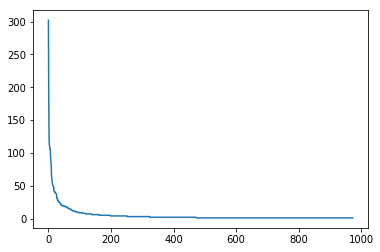

In [15]:
#Creating a figure and axis lets us do things like change the scaling or add a title
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

This shows that likelihood of a word occurring is inversely proportional to its rank. This effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), and suggests that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log (rank order) and log (frequency) resulting in a linear relationship.

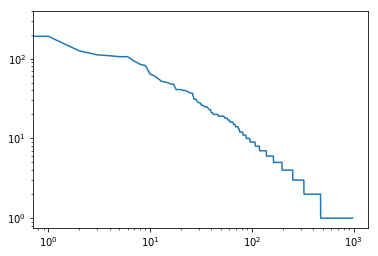

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

(The same relationship occurs in many other rankings, such as population ranks of cities, corporation sizes, income rankings, etc.) 

The distribution was imagined by Zipf to be driven by a principle of 'least effort' where speakers did not work any harder than necessary to communicate a given idea, but the basis for this relationship is still not well understood and conforms at least as well to a process of [preferential attachment](https://en.wikipedia.org/wiki/Preferential_attachment) whereby people disproportionately attend to popular words.


# Getting and working with raw text

First, we will retrieve a collection of press releases from a *GitHub API* that archived them, based on a number of analyses by Justin Grimmer, a political scientist whose work we will read in two weeks!

GitHub API requests are made to `'https://api.github.com/'` and responses are in JSON, similar to Tumblr's API.

We will get the information on [github.com/lintool/GrimmerSenatePressReleases](https://github.com/lintool/GrimmerSenatePressReleases) as it contains a nice set documents.

In [16]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases')
senateReleasesData = json.loads(r.text)
print(senateReleasesData.keys())
print("____________")
print(senateReleasesData['description'])

dict_keys(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'forks_count', 'mirror_url', 'archived', 'disabled', 'open_issues_count', 'lic

What we are interested in here is the `'contents_url'`

In [17]:
print(senateReleasesData['contents_url'])

https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/{+path}


We can use this to get any or all of the files from the repo.

In [18]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse')
whitehouseLinks = json.loads(r.text)
whitehouseLinks[0]

{'name': '10Apr2007Whitehouse123.txt',
 'path': 'raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'sha': 'f524289ee563dca58690c8d36c23dce5dbd9962a',
 'size': 2206,
 'url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
 'html_url': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'git_url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
 'download_url': 'https://raw.githubusercontent.com/lintool/GrimmerSenatePressReleases/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'type': 'file',
 '_links': {'self': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
  'git': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
  'html': 'https:/

Now we have a list of information about Whitehouse press releases. Let's look at one of them.

In [19]:
r = requests.get(whitehouseLinks[0]['download_url'])
whitehouseRelease = r.text
print(whitehouseRelease[:1000])
len(whitehouseRelease)

SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY IN PUSH FOR STEM CELL RESEARCH
  Sharing the story of Lila Barber, a 12 year old girl from Westerly, Sen. Sheldon Whitehouse (D-R.I.) on Tuesday, April 10, 2007, illustrated the hope stem cell research can offer in a speech on the Senate floor in favor of legislation to expand federal funding for stem cell research.  
   Whitehouse met Lila two weeks ago. She was diagnosed two years ago with osteosarcoma, a cancerous bone condition, and last year underwent cadaver bone transplant surgery. The procedure saved her leg and is helping her remain cancer-free, but the transplanted tissue will not grow with her and likely will break down over time. Stem cell research, Whitehouse explained, could vastly improve the care of patients like Lila by allowing surgeons to enhance transplants with a patient's own stem cells, which could replace the lost bone and cartilage, or grow entirely new replacement bones and joints. 
   "Stem cell research gives hope

2206

Now we have a string of correctly encoded text. For analysis of its words, next we need to tokenize it, or split it into a sequence of tokens or word instances.

In [20]:
whTokens = word_tokenize(whitehouseRelease)
whTokens[10:30]

['STEM',
 'CELL',
 'RESEARCH',
 'Sharing',
 'the',
 'story',
 'of',
 'Lila',
 'Barber',
 'a',
 '12',
 'year',
 'old',
 'girl',
 'from',
 'Westerly',
 'Sen.',
 'Sheldon',
 'Whitehouse',
 'D']

Previous iterations of the course used `nltk`s tokenizer, but as we saw before, we used spaCy's model (https://spacy.io/api/tokenizer). We intend to avoid using NLTK when we can - for production level code, it is a lot faster and cleaner to use spaCy.

That being said, `nltk` does have some useful methods for quick analysis of small corpuses. We will explore a few here, and encourage you to figure out for yourself which other ones might be useful.

To use the list of tokens in `nltk`, and take advantage of functions like `concordance`, shown above, we can convert it into a `Text`.

In [21]:
import nltk

In [22]:
whText = nltk.Text(whTokens)

whitehouseIndex = nltk.text.ConcordanceIndex(whText) 
whitehouseIndex.print_concordance('Whitehouse')

Displaying 5 of 5 matches:
ld girl from Westerly Sen. Sheldon Whitehouse D R.I. on Tuesday April 10 2007 il
ral funding for stem cell research Whitehouse met Lila two weeks ago She was dia
 down over time Stem cell research Whitehouse explained could vastly improve the
s research might help or even cure Whitehouse said Whitehouse also praised the e
 help or even cure Whitehouse said Whitehouse also praised the efforts of Rhode 


*Note* that the `Text` class is for doing rapid, exploratory analysis. It provides an easy interface to many of the operations we want to do, but it does not allow us much control over the particular operations it glosses. When you are doing a more complete analysis, you should be using the module specifically designed for that task instead of the shortcut method `Text` provides, e.g. use  [`collocations` Module](http://www.nltk.org/api/nltk.html#module-nltk.collocations) instead of `.collocations()`.

Now that we have gotten this loaded, let's glance at few features we will delve into more deeply later.

For example, we can find words that statistically tend to occur together and typically have a composite, idiomatic meaning irreducible to the semantics of its component words. We will do this later with more control over exactly how these are identified.

Or we can pick a word (or words) and find what words tend to occur around it.

In [23]:
whText.common_contexts(['stem'])

for_cell hope_cell time_cell own_cells joints_cell of_cell on_cells
the_cell embryonic_cells


We can also just count the number of times the word occurs.

In [24]:
whText.count('cell')

5


We can also plot each time a set of words occurs.

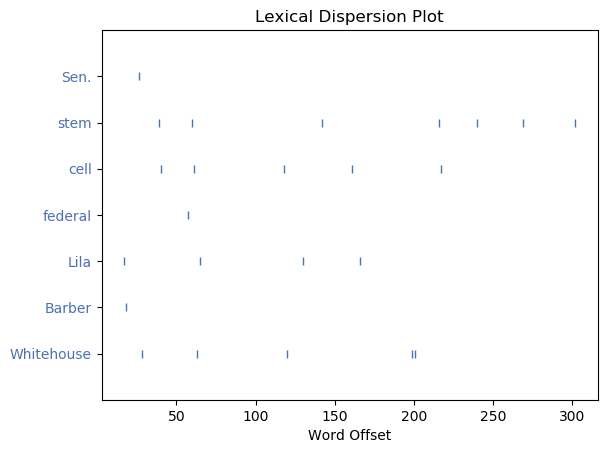

In [25]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Sen.','stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])
sns.set() #Re-enabling seaborn

If we want to do an analysis of all the Whitehouse press releases we will first need to obtain them. By looking at the API we can see the the URL we want is [https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse](https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse), so we can create a function to scrape the individual files.

If you want to know more about downloading from APIs, refer back to the 1st notebook.

In [26]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

whReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse', maxFiles = 10)
whReleases[:5]


countedWords = wordCounter(word_tokenize(clean_11[1]))
countedWords[:10]



NameError: name 'clean_11' is not defined

If you are having trouble downloading the data uncomment this next cell

In [28]:
#whReleases = pandas.read_csv('../data/whReleases.csv')

Now we have all the texts in a DataFrame we can look at a few things.

First let's tokenize the texts with the same tokenizer as we used before. We will just save the tokens as a list for now; no need to convert to `Text`s.

In [29]:
whReleases['tokenized_text'] = whReleases['text'].apply(lambda x: word_tokenize(x))

Now lets see how long each of the press releases is:

In [30]:
whReleases['word_counts'] = whReleases['tokenized_text'].apply(lambda x: len(x))
whReleases['word_counts']

0    350
1    311
2    497
3    189
4    236
5    334
6    241
7    469
8    443
9    425
Name: word_counts, dtype: int64

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </span>

In [2]:
#load raw txt file from corpus COCA
corpus = "/Users/Tianyi/Downloads/COCA"
def loadcorpus (corpus, corpus_style = "text"):
    text_raw = {}
    for file in os.listdir(corpus + "/"):
        #check if the zip file under COCA has "text" in its title
        if corpus_style in file:
            print(file)
            tfile=zipfile.ZipFile(corpus + "/" + file)
            # xfile is the file name in the zipfile
            for xfile in tfile.namelist():
                text_raw[xfile] = []
                with tfile.open(xfile) as f: #f is the opened txt 
                    for line in f:
                        text_raw[xfile].append(line)
    return text_raw

coca_raw = loadcorpus(corpus)



text_magazine_jex.zip
text_spoken_kde.zip
text_fiction_awq.zip
text_newspaper_lsp.zip
text_academic_rpe.zip
text_2012-2015_ksr.zip


In [4]:
coca_raw['w_fic_2012.txt'][0:3]



[b'\r\n',
 b'##4120102 " The only problem with leaving four car lengths in front of you is that four cars come in to fill up the space ! " Hannah Swensen complained to her sister Michelle , who was riding in the passenger seat of her cookie truck . " I \'m going forty . Do you think that \'s too slow ? " <p> " Absolutely not . It \'s nasty out there , and anybody who drives faster than forty on a night like this is crazy . " <p> " Or they come from other states and they do n\'t know anything about winter driving in Minnesota . I think I \'ll pull over as far as I can and let that whole herd of cars behind me pass . " <p> " Good idea . " <p> Hannah signaled and moved over as far as she could to encourage the other drivers to pass her . They probably thought she was being too cautious , but a thin film of water glistened on the asphalt surface of the highway , and the temperature was dropping fast . @ @ @ @ @ @ @ @ @ @ of minutes and there was no way Hannah wanted to sail off into the di

In [5]:
# clean raw txt file

def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

clean_fic_2012 = clean_raw_text(coca_raw['w_fic_2012.txt'])
clean_fic_2012[1]


'##4120102 " The only problem with leaving four car lengths in front of you is that four cars come in to fill up the space ! " Hannah Swensen complained to her sister Michelle , who was riding in the passenger seat of her cookie truck . " I\'m going forty . Do you think that\'s too slow ? " <p> " Absolutely not . It\'s nasty out there , and anybody who drives faster than forty on a night like this is crazy . " <p> " Or they come from other states and they don\'t know anything about winter driving in Minnesota . I think I\'ll pull over as far as I can and let that whole herd of cars behind me pass . " <p> " Good idea . " <p> Hannah signaled and moved over as far as she could to encourage the other drivers to pass her . They probably thought she was being too cautious , but a thin film of water glistened on the asphalt surface of the highway , and the temperature was dropping fast . @ @ @ @ @ @ @ @ @ @ of minutes and there was no way Hannah wanted to sail off into the ditch and land in t

In [9]:
#load spacy English
nlp = spacy.load("en")


In [7]:
# tokenize 

def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

word_tokenize(clean_fic_2012[1])


['4120102',
 'The',
 'only',
 'problem',
 'with',
 'leaving',
 'four',
 'car',
 'lengths',
 'in',
 'front',
 'of',
 'you',
 'is',
 'that',
 'four',
 'cars',
 'come',
 'in',
 'to',
 'fill',
 'up',
 'the',
 'space',
 'Hannah',
 'Swensen',
 'complained',
 'to',
 'her',
 'sister',
 'Michelle',
 'who',
 'was',
 'riding',
 'in',
 'the',
 'passenger',
 'seat',
 'of',
 'her',
 'cookie',
 'truck',
 'I',
 "'m",
 'going',
 'forty',
 'Do',
 'you',
 'think',
 'that',
 "'s",
 'too',
 'slow',
 '<',
 'p',
 '>',
 'Absolutely',
 'not',
 'It',
 "'s",
 'nasty',
 'out',
 'there',
 'and',
 'anybody',
 'who',
 'drives',
 'faster',
 'than',
 'forty',
 'on',
 'a',
 'night',
 'like',
 'this',
 'is',
 'crazy',
 '<',
 'p',
 '>',
 'Or',
 'they',
 'come',
 'from',
 'other',
 'states',
 'and',
 'they',
 'do',
 "n't",
 'know',
 'anything',
 'about',
 'winter',
 'driving',
 'in',
 'Minnesota',
 'I',
 'think',
 'I',
 "'ll",
 'pull',
 'over',
 'as',
 'far',
 'as',
 'I',
 'can',
 'and',
 'let',
 'that',
 'whole',
 'herd'

In [8]:
# counting words

def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

ficcountedWords = wordCounter(word_tokenize(clean_fic_2012[1]))
ficcountedWords[:10]

ficcountedWords.sort_values('count', ascending=False, inplace=True)
ficcountedWords[:50]



,word,count
1,the,202
17,to,87
52,and,84
45,>,81
44,p,81
43,<,81
58,a,48
40,'s,47
48,it,46
11,of,44


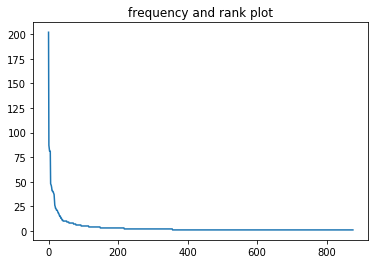

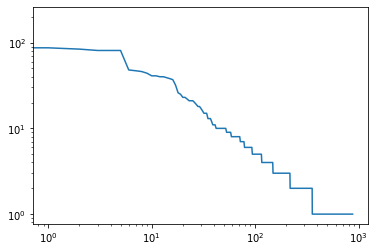

In [9]:
# frequency and rank plot
#Creating a figure and axis lets us do things like change the scaling or add a title
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(ficcountedWords)), ficcountedWords['count'])
plt.title("frequency and rank plot")
plt.show()



fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(ficcountedWords)), ficcountedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [26]:
# using nltk to tokenize, find concordance, and make lexical dispersion plot
import nltk


In [11]:
# find concordance 'truck'

fictokens = word_tokenize(clean_fic_2012[1]) 
fictext = nltk.Text(fictokens) #generating text file for concordance
ficindex = nltk.text.ConcordanceIndex(fictext)
ficindex.print_concordance('accident')



Displaying 7 of 7 matches:
 we did It sounds like a really bad accident < p > More than one accident It 's 
ly bad accident < p > More than one accident It 's a chain reaction They 're sti
p > Tell them it 's a multi vehicle accident and to come out here right away The
tal so he can set up to receive the accident victims < p > Got it Michelle said 
hts flashing as they approached the accident scene < p > It 's bad Michelle said
 emergency vehicles speeding to the accident site and the wind whistling through
re pretty impatient considering the accident happened less than five minutes ago


In [12]:
# nltk for word count 
fictext.count('sheriff')

2

In [13]:
# nltk to find common context for 'county'
fictext.common_contexts(['emergency'])

the_vehicles of_vehicles


/Users/Tianyi/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/Tianyi/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/Tianyi/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/Tianyi/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/Tianyi/opt/anaconda3/lib/python3.7/_collections_abc.py:841: Matpl

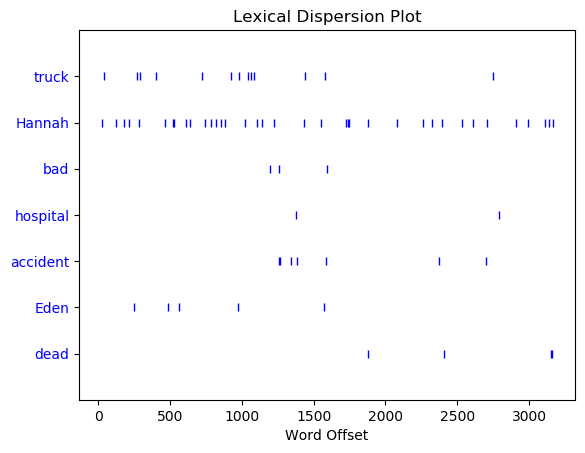

In [14]:
# make lexical dispersion plot
sns.reset_orig() #Seaborn messes with this plot, disabling it
fictext.dispersion_plot(['truck','Hannah', 'bad', 'hospital' ,'accident', 'Eden', 'dead'])
sns.set() #Re-enabling seaborn


The lexical dispersion plot is interesting because it sort of gives some idea about the plot of the novel. I googled and found that this is a novel titled "Cinnamon Roll Murder." Hannah is the main character's name and the story involves a multi-vehicle accident. The dispersion plot captures that - the accident happened in the middle of the book and someone was hospitalized after the first few mentions of the accident. This person probably died at the end of the book, as indicated by the dispersion plot - which is confirmed by the the synposis of the book. 


# Filtering and normalizing text

As we want to start comparing the different releases we may choose to do a bit of filtering and normalizing that will allow us to focus on what we most care about. We can first make all of the words lower case, then drop the non-word tokens. Next, we can remove some 'stop words', stem the remaining words to remove suffixes, prefixes and (in some languages) infixes, or lemmatize tokens by intelligently grouping inflected or variant forms of the same word (e.g., with a stemmer and a dictionary). 

To begin this process, we will first define a function to work over the tokenized lists, then another to add normalized tokens to a new column.

We will be using spaCy's built in stop words identifying capacity. When we run text through spaCy's language pipeline, it automatically tags it as a stop word. 

We can remove these stopwords from the analysis by fiat, but we could also take a more principled approach by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection. Alternatively, we could automatically set a cut-off by rule, such as removal of all words more frequent then the most frequent verb, or the most frequent noun (not pronoun), or some term of central interest. 

In [31]:
countsDict = {}
for word in whReleases['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('the', 179),
 ('of', 112),
 ('to', 112),
 ('and', 108),
 ('in', 64),
 ('a', 61),
 ("'s", 50),
 ('that', 41),
 ('our', 39),
 ('for', 35),
 ('is', 33),
 ('on', 33),
 ('Whitehouse', 31),
 ('Iraq', 28),
 ('Bush', 27),
 ('President', 25),
 ('troops', 21),
 ('by', 19),
 ('American', 19),
 ('Rhode', 18)]

We can look at this and pick the cutoff, usually it is at the first noun. So we will cut all words before `'Whitehouse'`.

In [32]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Whitehouse':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['the', 'of', 'to', 'and', 'in', 'a', "'s", 'that', 'our', 'for', 'is', 'on']

If we did have any extra words to add as stop words apart from those normally considered as stop words, we would add it to our stop words by passing it to the normalize tokens method. 

Now we can create our function to normalize the tokens

In [14]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [15]:
whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))

whReleases

NameError: name 'whReleases' is not defined

You can see that in the final step of normalizing, we add the lemmatized form of the word. spaCy's built in lemmatizer does this (https://spacy.io/api/lemmatizer). Lemmatization can be thought of as finding the root or the base of the word after removing inflections and other variations of words. Another possible way of finding the roots of words is using NLTK's porting or stemming functionalities, but we will not be getting into them.

Now that it is cleaned we start analyzing the dataset. We can start by finding frequency distributions for the dataset. Lets start looking at all the press releases together. The [`ConditionalFreqDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) class reads in an iterable of tuples, the first element is the condition and the second the focal word. For starters, we will use word lengths as the conditions, but tags or clusters will provide more useful results.

In [35]:
#.sum() adds together the lists from each row into a single list
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))

#print the number of words
print(whcfdist.N())

1966


From this we can lookup the distributions of different word lengths

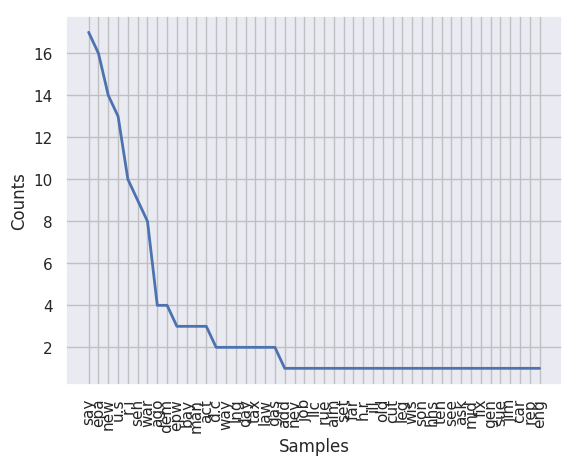

In [36]:
whcfdist[3].plot()

We can also create a Conditional Probability Distribution or [`ConditionalProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) from the `ConditionalFreqDist`. To do this, however, we need a model for the probability distribution. A simple model is [`ELEProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ELEProbDist) which gives the expected likelihood estimate for the probability distribution of the experiment used to generate the observed frequency distribution. 

In [37]:
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(whcpdist[2].max())

#And its probability
print(whcpdist[2].prob(whcpdist[2].max()))

ri
0.25


Length is one feature of a word, but there are many more important features we care about. Another critical feature is a word's role in the sentence, or its part of speech (POS). 

The method below works similarly to ```nltk.pos_text```, and can work with the conditional frequency distributions it provides.

In [38]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [39]:
whReleases['normalized_tokens_POS'] = [spacy_pos(t) for t in whReleases['text']]

This gives us a new column with the part of speech as a short initialism and the word in a tuple, exactly how the `nltk.ConditionalFreqDist()` function wants them. We can now construct another conditional frequency distribution.

In [40]:
whcfdist_WordtoPOS = nltk.ConditionalFreqDist(whReleases['normalized_tokens_POS'].sum())
list(whcfdist_WordtoPOS.items())[:10]

[('science', FreqDist({'NN': 1})),
 ('congressman', FreqDist({'NN': 1})),
 ('testimony', FreqDist({'NN': 1})),
 ('providence', FreqDist({'NN': 5, 'NNP': 4})),
 ('belonged', FreqDist({'VBD': 1})),
 ('third', FreqDist({'JJ': 1})),
 ('mercury', FreqDist({'NN': 1})),
 ('several', FreqDist({'JJ': 4})),
 ('york', FreqDist({'NNP': 1})),
 ('dredge', FreqDist({'VB': 1}))]

This gives the frequency of each word as each part of speech...which can be uninformative and boring.

What we want is the converse; the frequency of each part of speech for each word.

In [41]:
whcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in whReleases['normalized_tokens_POS'].sum())

We can now identify and collect all of the superlative adjectives

In [42]:
whcfdist_POStoWord['JJ']

FreqDist({'american': 17, 'new': 10, 'portuguese': 9, 'political': 8, 'federal': 6, 'potential': 5, 'clear': 5, 'fiscal': 5, 'official': 4, 'several': 4, ...})

Or look at the most common nouns

In [43]:
whcfdist_POStoWord['NN'].most_common(5)

[('today', 15),
 ('year', 12),
 ('administration', 11),
 ('consulate', 10),
 ('stem', 10)]

Or plot the base form verbs against their number of occurrences

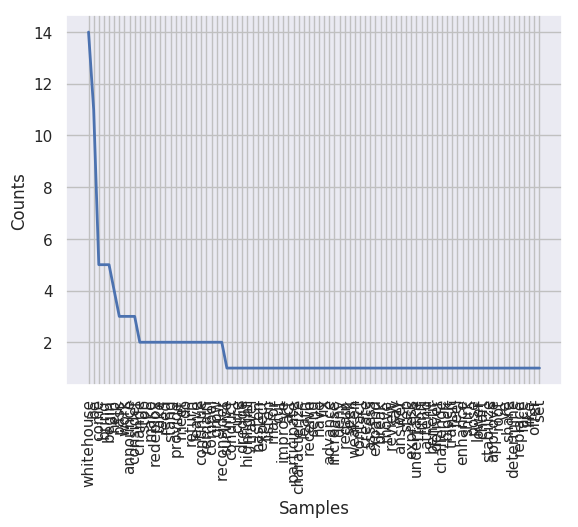

In [44]:
whcfdist_POStoWord['VB'].plot()

We can then do a similar analysis of the word probabilities

In [45]:
whcpdist_POStoWord = nltk.ConditionalProbDist(whcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(whcpdist_POStoWord['NN'].max())

#And its probability
print(whcpdist_POStoWord['NN'].prob(whcpdist_POStoWord['NN'].max()))

today
0.020195439739413682


We can even create a...wait for it...*WORD CLOUD* or Wordl to gaze at and draw mystical, approximate inferences about important nouns and verbs in our corpus:

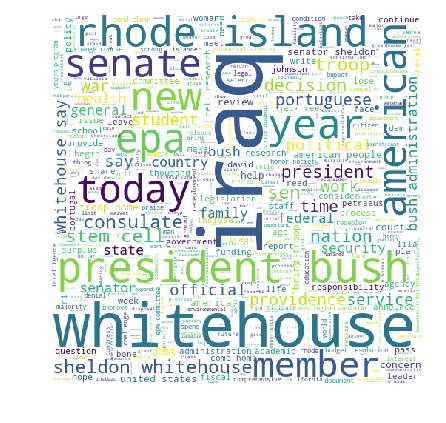

In [46]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(whReleases['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("whitehouse_word_cloud.pdf", format = 'pdf')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</span>

In [15]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [10]:
#load spacy English
nlp = spacy.load("en")

In [16]:
# normalize
clean_fic_df = pandas.DataFrame()
clean_fic_df['text'] = clean_fic_2012
clean_fic_df['tokenize_fic'] = clean_fic_df['text'].apply(lambda x: word_tokenize(x))
clean_fic_df['normalized_tokens'] =clean_fic_df['tokenize_fic'].apply(lambda x: normalizeTokens(x))
clean_fic_df['normalized_tokens_count'] = clean_fic_df['normalized_tokens'].apply(lambda x: len(x))



In [17]:
print(clean_fic_df['normalized_tokens_count'].head())

0       0
1    1483
2    1419
3     854
4    1392
Name: normalized_tokens_count, dtype: int64


In [18]:
print(clean_fic_df.head())

                                                text  \
0                                               \r\n   
1  ##4120102 " The only problem with leaving four...   
2  ##4120103 Waiting for spring in Reno , Nevada ...   
3  ##4120106 One hour down . Three hours to go . ...   
4  ##4120107 After dinner with the first couple ,...   

                                        tokenize_fic  \
0                                                 []   
1  [4120102, The, only, problem, with, leaving, f...   
2  [4120103, Waiting, for, spring, in, Reno, Neva...   
3  [4120106, One, hour, down, Three, hours, to, g...   
4  [4120107, After, dinner, with, the, first, cou...   

                                   normalized_tokens  normalized_tokens_count  
0                                                 []                        0  
1  [problem, leave, car, length, car, come, fill,...                     1483  
2  [wait, spring, reno, nevada, like, play, weath...                     1419  
3  [ho

In [19]:
#.sum() adds together the lists from each row into a single list
ficcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in clean_fic_df['normalized_tokens'].sum()))

#print the number of words
print(ficcfdist.N())

1160050


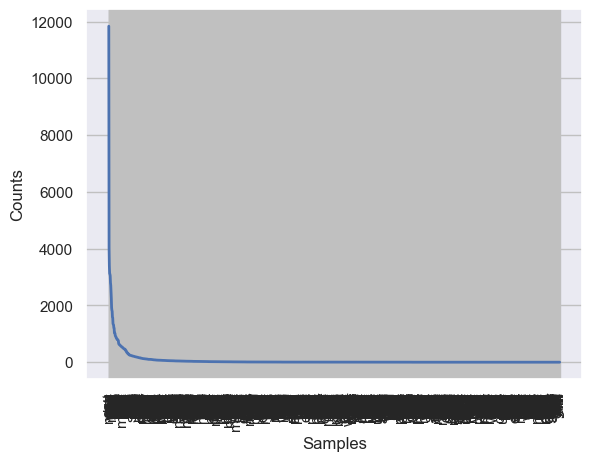

In [37]:
#distribution of word length
ficcfdist[3].plot()

In [38]:
#word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. 
#conditional prob #1 with ELEProbDist
ficcpdist1 = nltk.ConditionalProbDist(ficcfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(ficcpdist1[2].max())

#And its probability
print(ficcpdist1[2].prob(ficcpdist1[2].max()))

go
0.29402497027348395


In [39]:
# POS 
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

clean_fic_df['normalized_tokens_POS'] = [spacy_pos(t) for t in clean_fic_df['text']]

In [40]:
##conditional prob #2 with nltk.probability.FreqDist
ficcfdist_WordtoPOS = nltk.ConditionalFreqDist(clean_fic_df['normalized_tokens_POS'].sum())
list(ficcfdist_WordtoPOS.items())[:10]


[('\r\n', FreqDist({'_SP': 508})),
 ('#', FreqDist({'$': 1032, 'NN': 32, 'NNP': 7})),
 ('4120102', FreqDist({'CD': 1})),
 ('"', FreqDist({"''": 52997, '``': 37367})),
 ('the', FreqDist({'DT': 114193})),
 ('only', FreqDist({'RB': 2362, 'JJ': 694})),
 ('problem', FreqDist({'NN': 337})),
 ('with', FreqDist({'IN': 14942, 'RP': 1})),
 ('leaving', FreqDist({'VBG': 357, 'NN': 6})),
 ('four', FreqDist({'CD': 702}))]

In [41]:
ficcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in clean_fic_df['normalized_tokens_POS'].sum())

In [42]:
#all the adjectives
ficcfdist_POStoWord['JJ']


FreqDist({'other': 2664, 'good': 2240, 'old': 2104, 'little': 2062, 'first': 1651, 'few': 1563, 'own': 1506, 'last': 1496, 'new': 1371, 'long': 1286, ...})

In [43]:
#most common words
ficcfdist_POStoWord['NN'].most_common(5)

[('p', 38085),
 ('time', 4042),
 ('way', 2867),
 ('man', 2860),
 ('something', 2432)]

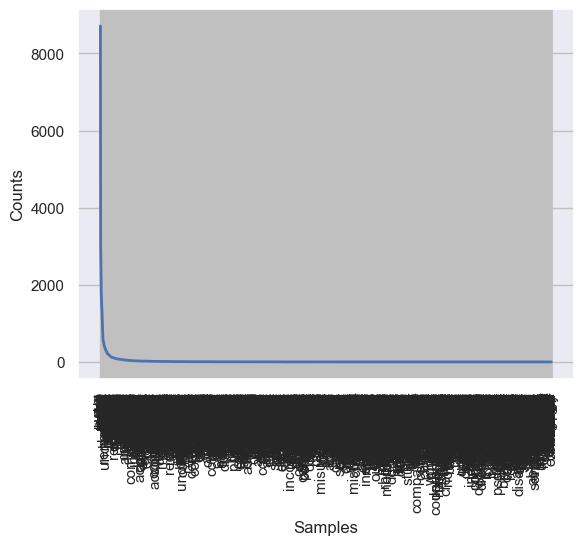

In [37]:
#verbs and their number of occurrences
ficcfdist_POStoWord['VB'].plot()

In [44]:
ficcpdist_POStoWord = nltk.ConditionalProbDist(ficcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(ficcpdist_POStoWord['NN'].max())

#And its probability
print(ficcpdist_POStoWord['NN'].prob(ficcpdist_POStoWord['NN'].max()))

p
0.101058734560121


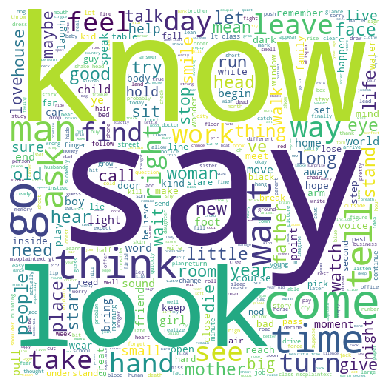

In [45]:
#wordl of words 
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(clean_fic_df['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("fic_word_cloud.pdf", format = 'pdf')


From the word cloud, it seems the most significant words in the book are verbs that either involves moving physically ("say,come,look, go") or some kind of mental activity ("know"). This seems to suggest that there are a lot of actions happening in the book. Some other words that are interesting to note are "day" and "time" which means the book is sensitive to time, which makes sense because the book involves car accidents and death (or possible murder), both are sensitive to time. 


## Davies Corpora

Now that we have our basic cleaning down, we can arrange our Davies Corpora. Let us try this with the movies corpora we have already loaded.

We'll use a smaller corpus of a 1000 movies for this demonstration.

In [47]:
zfile = zipfile.ZipFile(corpus_name + "/sources_movies.zip")
source = []

In [48]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [49]:
source[0:20]

[b'textID\tfileID\t#words\tgenre\tyear\tlanguage(s)\tcountry\timdb\ttitle\r\n',
 b'-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\r\n',
 b'\r\n',
 b'290635\t3547424\t4722\tShort, Musical\t1930\tUK\tEnglish\t0290635\tGoodbye to All That\r\n',
 b'21165\t6332374\t10220\tCrime, Mystery, Thriller\t1930\tUK\tEnglish\t0021165\tMurder!\r\n',
 b'21191\t6013789\t5281\tDrama, Romance\t1930\tUSA\tEnglish\t0021191\tA Notorious Affair\r\n',
 b'20620\t3660608\t6724\tBiography, Drama, History\t1930\tUSA\tEnglish\t0020620\tAbraham Lincoln\r\n',
 b'20629\t60053\t9552\tDrama, War\t1930\tUSA\tEnglish, French, German, Latin\t0020629\tAll Quiet on the Western Front\r\n',
 b'20640\t6850720\t13862\tComedy, Musical\t1930\tUSA\tEnglish\t0020640\tAnimal Crackers\r\n',
 b'20641\t176501\t11140\tDrama, Romance\t1930\tUSA\tEnglish\t0020641\tAnna Christie\r\n',
 b'20643\t3603861\t1748\tComedy, Short\t1930\tUSA\tEnglish\t0020643\tAnother Fine Mess\r\n',
 b'20670\t4159455\t6966\tComedy, Musical\t1930\tUS

It looks dirty because the file is encoded as bytes, but we can certainly see the information in here. The file id is also present in the original raw text data: as the first "word". Look back at the normalized/tokenized words to confirm that. We're going to use this to create a dataframe with: Fileid, movie name, genre, year, and country.

It is advised that you run a similar check of the source file before you do other extraction.

First, let us create a dictionary mapping file-id to all the text. Each movie will be mapped to a list of the tokenized words.

In this example, I only use it to load 100 movies. You can comment this out or increase/decrease the number as you see fit.

In [50]:
movie_texts = {}

In [51]:
for files in movie_raw:
    if len(movie_texts) > 100:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        txts = lucem_illud_2020.word_tokenize(movie)
        try:
            movie_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

In [52]:
import pandas as pd

In [53]:
movie_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country", "Tokenized Texts"])

In [54]:
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), movie_texts[fileid.strip()]]
    except KeyError:
        continue

In [55]:
movie_df.head()

,Movie Name,Genre,Year,Country,Tokenized Texts
6794028,Laughter,"Comedy, Romance",1930,English,"[So, I, can, call, up, tomorrow, can, I, Pearl..."
3255963,Monte Carlo,"Comedy, Musical, Romance",1930,"English, French","[Day, of, days, Wonderful, day, of, love, Beau..."
3116385,The Chain Gang,"Animation, Short, Comedy",1930,English,"[Shut, up, you, Y, Y, Y, Y, Yes, ma'am, Compan..."
3547483,A Co-respondent's Course,Comedy,1931,English,"[OOZE, WHO, HELLO, CREEPS, I, LL, BE, WITH, YO..."
6649883,Pardon Us,"Comedy, Crime, Drama",1931,"English, Italian","[Laurel, and, Hardy, Pardon, Us, Comedy, 1931,..."


# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. We will be using the in-built spaCy pos-tagging.

https://spacy.io/usage/linguistic-features

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

spaCy pos-tags word as we run it through the english language model. A small example:

In [56]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")


In [57]:
for token in sent:
    print(token.text, token.pos_, token.tag_)

Tom PROPN NNP
went VERB VBD
to ADP IN
IKEA PROPN NNP
to PART TO
get AUX VB
some DET DT
of ADP IN
those DET DT
delicious ADJ JJ
Swedish ADJ JJ
meatballs NOUN NNS
. PUNCT .


This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [58]:
redditDF = pandas.read_csv('../data/reddit.csv')

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word). Here, we will use sentences tokenized by spaCy. Like before, these methods can also be found in lucem_illud.



In [59]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [60]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores

,Unnamed: 0,author,over_18,score,subreddit,text,title,url,sentences
9,8,brenkelieshere,False,9448,Tales From Tech Support,"Last year, Help Desk got a call from a user co...",How to fix a laptop that won't boot in under a...,https://www.reddit.com/r/talesfromtechsupport/...,"[[Last, year, Help, Desk, got, a, call, from, ..."
8,7,Bombadils,False,10528,Tales From Tech Support,First post in quite some time! I work at a loc...,"OK, now the password is 'D35p41r'",https://www.reddit.com/r/talesfromtechsupport/...,"[[First, post, in, quite, some, time], [I, wor..."
7,1200,whenlifegivesyoushit,False,11003,Relationships,[Original Post](https://www.reddit.com/r/relat...,[UPDATE]My [26 F] with my husband [29 M] 1 yea...,https://www.reddit.com/r/relationships/comment...,"[[Original, Post](https://www.reddit.com, r, r..."
6,6,sfsdfd,False,11295,Tales From Tech Support,I witnessed this astounding IT meltdown around...,"Company-wide email + 30,000 employees + auto-r...",https://www.reddit.com/r/talesfromtechsupport/...,"[[I, witnessed, this, astounding, IT, meltdown..."
5,5,Raitaro,False,12372,Tales From Tech Support,I work Helpdesk for a retail store chain in th...,I'm pretty sure I knocked a user out from near...,https://www.reddit.com/r/talesfromtechsupport/...,"[[I, work, Helpdesk, for, a, retail, store, ch..."
4,4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,"[[This, just, happened], [So, I, had, a, lapto..."
3,3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...,"[[Another, tale, from, the, out, of, hours], [..."
2,2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...,"[[Part, 1](http://www.reddit.com, r, talesfrom..."
1,1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...,"[[>], [$, Me], [Hello, IT], [>, $], [Usr, Hi, ..."
0,0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...,"[[So, my, story, starts, on, what, was, a, nor..."


In [61]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [62]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_pos(x))

In [63]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (Help, NNP), (Desk, ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, P...
7    [[(Original, NNP), (Post](https://www.reddit.c...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBD)], [(...
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[(Part, NN), (1](http://www.reddit.com, CD), ...
1    [[(>, XX)], [($, $)], [(Me, PRP)], [(Hello, UH...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [64]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('m', 21),
 ('password', 21),
 ('time', 14),
 ('computer', 13),
 ('lot', 12),
 ('life', 11),
 ('email', 11),
 ('system', 10),
 ('auto', 9),
 ('laptop', 9),
 ('day', 9),
 ('message', 9),
 ('Genius', 9),
 ('office', 8),
 ('story', 8),
 ('call', 8),
 ('today', 8),
 ('part', 8),
 ('job', 7),
 ('something', 7)]

What about the adjectives that modify the word, "computer"?

In [65]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'own', 'unrestricted'}


## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In [ ]:
# normalize
#clean_fic_df = pandas.DataFrame()
#clean_fic_df['text'] = clean_fic_2012
#clean_fic_df['tokenize_fic'] = clean_fic_df['text'].apply(lambda x: word_tokenize(x))
#clean_fic_df['normalized_tokens'] =clean_fic_df['tokenize_fic'].apply(lambda x: normalizeTokens(x))
#clean_fic_df['normalized_tokens_count'] = clean_fic_df['normalized_tokens'].apply(lambda x: len(x))




In [ ]:
#clean_fic_df['sentence'] = clean_fic_df['text']

In [30]:
#print(clean_fic_df['text'][1:11])
#[elem1, elem2, ...]
# want each element to separate into two pieces
# for each element in this array
#    separate the element into two pieces
#    and store them separately

# Question here:
# How pandas takes an dictionary and convert it to an dataframe?
#  dictionary = 
# {
#  "title": [title1, title2, title3, ...]
#  "body": [body1, body2, body2, ...]
# }

clean_fic = {"title":[],
            "body":[]}

for r in clean_fic_df['text'][1:11]: #this is a list,
    clean_fic["title"].append(r[2:9])
    clean_fic["body"].append(r[9:])
    
# clean_fic
# { "title": [##4300023, ## 4769134, ...]
#    "body": [they ..., we ...., ]
# }
# sample of c
# 012345678910
# ##4120107 After dinner with the first co <-this is a string
#
new_fic_df = pandas.DataFrame.from_dict(clean_fic)
new_fic_df.head(10)

,title,body
0,4120102,""" The only problem with leaving four car leng..."
1,4120103,"Waiting for spring in Reno , Nevada , is like..."
2,4120106,One hour down . Three hours to go . <p> The a...
3,4120107,"After dinner with the first couple , Ida , Ma..."
4,4120108,"The letter , contemplated and worried about f..."
5,4120110,The starship Herodotus left Earth in 2210 wit...
6,4120111,JUN DO 'S mother was a singer . That was all ...
7,4120112,The man had taken his own family hostage . <p...
8,4120113,We did not go for a walk on the first day of ...
9,4120114,"NOVEMBER <p> Sangin District , Helmand Provin..."


In [31]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [32]:
new_fic_df['sentences'] = new_fic_df['body'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])

In [33]:
new_fic_df.index = range(len(new_fic_df) - 1, -1,-1) #Reindex to make things nice in the future
new_fic_df

,title,body,sentences
9,4120102,""" The only problem with leaving four car leng...","[[The, only, problem, with, leaving, four, car..."
8,4120103,"Waiting for spring in Reno , Nevada , is like...","[[Waiting, for, spring, in, Reno, Nevada, is, ..."
7,4120106,One hour down . Three hours to go . <p> The a...,"[[One, hour, down], [Three, hours, to, go], [<..."
6,4120107,"After dinner with the first couple , Ida , Ma...","[[After, dinner, with, the, first, couple, Ida..."
5,4120108,"The letter , contemplated and worried about f...","[[The, letter, contemplated, and, worried, abo..."
4,4120110,The starship Herodotus left Earth in 2210 wit...,"[[The, starship, Herodotus, left, Earth, in, 2..."
3,4120111,JUN DO 'S mother was a singer . That was all ...,"[[JUN, DO, 'S, mother, was, a, singer], [That,..."
2,4120112,The man had taken his own family hostage . <p...,"[[The, man, had, taken, his, own, family, host..."
1,4120113,We did not go for a walk on the first day of ...,"[[We, did, not, go, for, a, walk, on, the, fir..."
0,4120114,"NOVEMBER <p> Sangin District , Helmand Provin...","[[NOVEMBER, <, p], [>, Sangin, District, Helma..."


In [34]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [35]:
## POS tagging
new_fic_df['POS_sents'] = new_fic_df['sentences'].apply(lambda x: tag_sents_pos(x))

new_fic_df['POS_sents']


9    [[(The, DT), (only, JJ), (problem, NN), (with,...
8    [[(Waiting, VBG), (for, IN), (spring, NN), (in...
7    [[(One, CD), (hour, NN), (down, RB), (Three, C...
6    [[(After, IN), (dinner, NN), (with, IN), (the,...
5    [[(The, DT), (letter, NN), (contemplated, VBD)...
4    [[(The, DT), (starship, NN), (Herodotus, NNP),...
3    [[(JUN, NNP), (DO, NNP), ('S, POS), (mother, N...
2    [[(The, DT), (man, NN), (had, VBD), (taken, VB...
1    [[(We, PRP), (did, VBD), (not, RB), (go, VB), ...
0    [[(NOVEMBER, NNP), (<, XX), (p, NN), (>, XX), ...
Name: POS_sents, dtype: object

In [36]:
# count the number of nouns
countTarget = 'NN'
targetCounts = {}
for entry in new_fic_df['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('p', 780),
 ('way', 44),
 ('time', 37),
 ('m', 36),
 ('room', 31),
 ('anything', 26),
 ('door', 23),
 ('hand', 22),
 ('water', 21),
 ('life', 21),
 ('lady', 21),
 ('glass', 20),
 ('man', 20),
 ('something', 19),
 ('mother', 19),
 ('window', 18),
 ('place', 18),
 ('family', 17),
 ('day', 17),
 ('truck', 16)]

In [41]:
## verb
countTarget = 'VB'
targetCounts = {}
for entry in new_fic_df['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]


[('be', 82),
 ('have', 59),
 ('do', 44),
 ('get', 41),
 ('know', 23),
 ('think', 20),
 ('go', 20),
 ('see', 18),
 ('come', 17),
 ('make', 17),
 ('let', 16),
 ('want', 16),
 ('help', 15),
 ('take', 15),
 ('say', 15),
 ('hear', 15),
 ('read', 13),
 ('Do', 13),
 ('tell', 11),
 ('keep', 10)]

In [37]:
# adjectives
countTarget = 'JJ'
targetCounts = {}
for entry in new_fic_df['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]


[('shy', 39),
 ('other', 37),
 ('first', 34),
 ('good', 28),
 ('small', 23),
 ('old', 22),
 ('own', 18),
 ('right', 17),
 ('few', 17),
 ('little', 17),
 ('human', 15),
 ('last', 13),
 ('same', 13),
 ('new', 13),
 ('several', 12),
 ('open', 12),
 ('long', 11),
 ('enough', 11),
 ('deep', 10),
 ('dead', 10)]

In [40]:
# things/names that go with the adjective "shy"
NTarget = 'NNP'
Word = 'shy'
NResults = set()
for entry in new_fic_df['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)    

{'Destiny', 'and-', 'estraphen', 'three-', 'Greater-', 'Diaz', 'Sauer'}


In [42]:
# "shy" with proper nouns
NTarget = 'NN'
Word = 'shy'
NResults = set()
for entry in new_fic_df['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)    

{'richie-', 'shit', 'ten-', 'third-', 'roof', 'air-', 'first-', 'file', 'condition', 'bullet-', 'skill-', 'freak-', 'hostage-', 'double-', 'night'}


In [39]:
# things/names that go with the adjective "dead" (hoping to find the name of the character who's dead)
NTarget = 'NN'
Word = 'dead'
NResults = set()
for entry in new_fic_df['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)  

{'everyone', 'long-'}


I was at first hoping to find out the name of the character who was dead but the POS tag did not help, but the fact that "dead" is used to modify "everyone" does indicate that the traffic accident

In [ ]:
#  Title       |     Body |
#  4120106     |     text here
# ...         |  ....


# Collocations

As illustrated above, we might want to find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (*n*-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length *n*). 

We will begin with the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-grams.

In [66]:
whBigrams = nltk.collocations.BigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(whBigrams.N))

There are 1966 bigrams in the finder


To compare the bigrams we need to tell nltk what our score function is. Initially, we will look at the raw counts.

In [67]:
def bigramScoring(count, wordsTuple, total):
    return count

print(whBigrams.nbest(bigramScoring, 10))

[('president', 'bush'), ('rhode', 'island'), ('sheldon', 'whitehouse'), ('stem', 'cell'), ('whitehouse', 'd'), ('d', 'r.i'), ('bush', 'administration'), ('whitehouse', 'say'), ('american', 'people'), ('bring', 'troop')]


One note about how `BigramCollocationFinder` works. It doesn't use the strings internally.

In [68]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

whBigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The first word is:  5, The second word is: 3
The first word is:  17, The second word is: 3
The first word is:  4, The second word is: 6
The first word is:  4, The second word is: 3
The first word is:  4, The second word is: 32
The first word is:  1, The second word is: 2
The first word is:  1, The second word is: 15
The first word is:  10, The second word is: 4
The first word is:  3, The second word is: 6
The first word is:  1, The second word is: 4


The words are each given numeric IDs and there is a dictionary that maps the IDs to the words they represent. This is a common performance optimization.

Two words can appear together by chance. Recall from  Manning and Schütze's textbook that a t-value can be computed for each bigram to see how significant the association is. You may also want to try computing the $\chi^2$, likelihood ratio, and pointwise mutual information statistics. 

In [69]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
whBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('rhode', 'island'), 178.4626724897413),
 (('stem', 'cell'), 146.29899697399068),
 (('president', 'bush'), 126.26729276568966),
 (('sheldon', 'whitehouse'), 97.4298528095992),
 (('d', 'r.i'), 84.9146961271807),
 (('united', 'states'), 81.48563202934115),
 (('whitehouse', 'd'), 57.76763043351339),
 (('senator', 'sheldon'), 49.72259487860021),
 (('jack', 'reed'), 46.48119675073579),
 (('american', 'people'), 46.36945188839907),
 (('bush', 'administration'), 45.46512896674145),
 (('honor', 'society'), 44.90628391896907),
 (('bring', 'troop'), 43.09168928304577),
 (('cell', 'research'), 41.09314736916158),
 (('d', 'ri'), 39.02133612474179),
 (('potential', 'closing'), 38.1761672488765),
 (('youth', 'program'), 38.1761672488765),
 (('u.s', 'senator'), 37.29814426167994),
 (('troop', 'home'), 36.67811523401771),
 (('come', 'home'), 36.52843915939549),
 (('epw', 'committee'), 34.32127210844136),
 (('whitehouse', 'say'), 33.11262200306782),
 (('budget', 'resolution'), 32.092896259399076),
 (

There are a few other available measures

In [70]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

We can also look at trigrams

In [71]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('sheldon', 'whitehouse', 'd'), 3.1616100497095263),
 (('whitehouse', 'd', 'r.i'), 2.6450863551309975),
 (('bring', 'troop', 'home'), 2.449193154185041),
 (('senator', 'sheldon', 'whitehouse'), 2.4489320548208684),
 (('stem', 'cell', 'research'), 2.2359180252547137),
 (('u.s', 'senator', 'sheldon'), 2.2358694296197354),
 (('senate', 'youth', 'program'), 1.732017198625133),
 (('united', 'states', 'senator'), 1.7319916558278872),
 (('jack', 'reed', 'd'), 1.7319695486115574),
 (('new', 'direction', 'iraq'), 1.7318500501449103),
 (('rhode', 'island', 'state'), 1.7316952996306025),
 (('whitehouse', 'd', 'ri'), 1.7316445127822775),
 (('sen', 'sheldon', 'whitehouse'), 1.7314055158489832),
 (('reconsider', 'potential', 'closing'), 1.4142080740555638),
 (('responsibility', 'security', 'governance'), 1.414204781065045),
 (('$', 'foregone', 'surplus'), 1.4142018539623618),
 (('senators', 'jack', 'reed'), 1.4142018539623618),
 (('v.', 'epa', 'decide'), 1.4142018539623618),
 (('cell', 'enhancemen

Or n-grams (for any number n)

In [72]:
Ngrams = nltk.ngrams(whReleases['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('iraq', 'sen', 'sheldon', 'whitehouse'): 2, ('stem', 'cell', 'research', 'whitehouse'): 2, ('u.s', 'senators', 'jack', 'reed'): 2, ('sen', 'sheldon', 'whitehouse', 'd'): 2, ('reed', 'd', 'r.i', 'sheldon'): 2, ('senators', 'jack', 'reed', 'd'): 2, ('portuguese', 'american', 'citizen', 'rhode'): 2, ('d', 'ri', 'say', 'today'): 2, ('senator', 'sheldon', 'whitehouse', 'd'): 5, ('american', 'citizen', 'rhode', 'island'): 2, ('jack', 'reed', 'd', 'r.i'): 2, ('bring', 'troop', 'home', 'iraq'): 2, ('sheldon', 'whitehouse', 'd', 'r.i'): 7, ('california', 'rhode', 'island', 'state'): 2, ('begin', 'bring', 'troop', 'home'): 2, ('u.s', 'senator', 'sheldon', 'whitehouse'): 5, ('whitehouse', 'd', 'ri', 'say'): 2, ('member', 'senate', 'select', 'committee'): 2, ('senate', 'select', 'committee', 'intelligence'): 2, ('r.i', 'sheldon', 'whitehouse', 'd'): 2, ('d', 'r.i', 'sheldon', 'whitehouse'): 2, ('stem', 'cell', 'enhancement', 'act'): 2, ('sheldon', 'whitehouse', 'd', 'ri'): 3}


Gensim is another important python text processing package which allows us to use collocations, among other cool methods (which we will explore later weeks).

In [73]:
import gensim

In [74]:
bigram = gensim.models.Phrases(whReleases['normalized_tokens'])

In [75]:
texts = [bigram[line] for line in whReleases['normalized_tokens']]

In [76]:
texts[0]

['sen',
 'whitehouse',
 'share',
 'westerly',
 'girl',
 'story',
 'push',
 'stem_cell',
 'research',
 'share',
 'story',
 'lila',
 'barber',
 'year',
 'old',
 'girl',
 'westerly',
 'sen',
 'sheldon_whitehouse',
 'd_r.i',
 'tuesday',
 'april',
 'illustrate',
 'hope',
 'stem_cell',
 'research',
 'offer',
 'speech',
 'senate',
 'floor',
 'favor',
 'legislation',
 'expand',
 'federal',
 'funding',
 'stem_cell',
 'research',
 'whitehouse',
 'meet',
 'lila',
 'week',
 'ago',
 'diagnose',
 'year',
 'ago',
 'osteosarcoma',
 'cancerous',
 'bone',
 'condition',
 'year',
 'undergo',
 'cadaver',
 'bone',
 'transplant',
 'surgery',
 'procedure',
 'save',
 'leg',
 'help',
 'remain',
 'cancer',
 'free',
 'transplanted',
 'tissue',
 'grow',
 'likely',
 'break',
 'time',
 'stem_cell',
 'research',
 'whitehouse',
 'explain',
 'vastly',
 'improve',
 'care',
 'patient',
 'like',
 'lila',
 'allow',
 'surgeon',
 'enhance',
 'transplant',
 'patient',
 'stem_cell',
 'replace',
 'lose',
 'bone',
 'cartilage',


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<span style="color:red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</span> 

I found a dataset on Kaggle that contains all the characters' dialogues from GOT season 1 to season 8. In the following exercise, I will be using this dataset since it will be more interesting.  

In [11]:
#import csv
GOT_df = pandas.read_csv(os.path.join(os.getcwd(), 'Game_of_Thrones_Script.csv'))

In [12]:
GOT_df.head(10)

,Release Date,Season,Episode,Episode Title,Name,Sentence
0,2011-04-17,Season 1,Episode 1,Winter is Coming,waymar royce,What do you expect? They're savages. One lot s...
1,2011-04-17,Season 1,Episode 1,Winter is Coming,will,I've never seen wildlings do a thing like this...
2,2011-04-17,Season 1,Episode 1,Winter is Coming,waymar royce,How close did you get?
3,2011-04-17,Season 1,Episode 1,Winter is Coming,will,Close as any man would.
4,2011-04-17,Season 1,Episode 1,Winter is Coming,gared,We should head back to the wall.
5,2011-04-17,Season 1,Episode 1,Winter is Coming,royce,Do the dead frighten you?
6,2011-04-17,Season 1,Episode 1,Winter is Coming,gared,Our orders were to track the wildlings. We tra...
7,2011-04-17,Season 1,Episode 1,Winter is Coming,royce,You don't think he'll ask us how they died? Ge...
8,2011-04-17,Season 1,Episode 1,Winter is Coming,will,Whatever did it to them could do it to us. The...
9,2011-04-17,Season 1,Episode 1,Winter is Coming,royce,It's a good thing we're not children. You want...


In [13]:
#filter Tyrion Lannister's sentences
tyrionfilter = GOT_df['Name']== "tyrion lannister"
tyrion_df = GOT_df[tyrionfilter]
tyrion_df.head(10)


,Release Date,Season,Episode,Episode Title,Name,Sentence
145,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,Mmh. It is true what they say about the Northe...
147,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,I did hear something about that.
149,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,And the other brother?
151,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,There's the pretty one. And there's the clever...
153,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,I hear he hates that nickname.
155,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,Clever girl.
157,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,Have you?
158,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,The gods gave me one blessing.
161,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,Should I explain to you the meaning of a close...
163,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,"She has odd cravings, our sister."


In [14]:
# tokenize 

def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized


In [15]:
# normalize
#clean_fic_df = pandas.DataFrame()
#clean_fic_df['text'] = clean_fic_2012
#clean_fic_df['tokenize_fic'] = clean_fic_df['text'].apply(lambda x: word_tokenize(x))
#clean_fic_df['normalized_tokens'] =clean_fic_df['tokenize_fic'].apply(lambda x: normalizeTokens(x))
#clean_fic_df['normalized_tokens_count'] = clean_fic_df['normalized_tokens'].apply(lambda x: len(x))



In [22]:
tyrion_df["tokenized"] = tyrion_df["Sentence"].apply(lambda x: word_tokenize(x))
tyrion_df["tokenized"].head()

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


145    [Mmh, It, is, true, what, they, say, about, th...
147               [I, did, hear, something, about, that]
149                           [And, the, other, brother]
151    [There, 's, the, pretty, one, And, there, 's, ...
153                 [I, hear, he, hates, that, nickname]
Name: tokenized, dtype: object

In [23]:
# normalize
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [24]:
tyrion_df['normalized_tokens'] = tyrion_df["tokenized"].apply(lambda x: normalizeTokens(x))

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
tyrion_df['normalized_tokens'].head()

145    [mmh, true, northern, girl]
147                         [hear]
149                      [brother]
151               [pretty, clever]
153         [hear, hate, nickname]
Name: normalized_tokens, dtype: object

In [27]:
# bigrams

TyrionBigrams = nltk.collocations.BigramCollocationFinder.from_words(tyrion_df['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(TyrionBigrams.N))


There are 10310 bigrams in the finder


In [28]:
def bigramScoring(count, wordsTuple, total):
    return count

print(TyrionBigrams.nbest(bigramScoring, 10))

[('king', 'landing'), ('casterly', 'rock'), ('m', 'sure'), ('m', 'sorry'), ('ned', 'stark'), ('hand', 'king'), ('jon', 'snow'), ('lady', 'stark'), ('night', 'watch'), ('m', 'afraid')]


In [29]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

TyrionBigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The first word is:  1, The second word is: 12
The first word is:  12, The second word is: 5
The first word is:  5, The second word is: 27
The first word is:  27, The second word is: 45
The first word is:  45, The second word is: 37
The first word is:  37, The second word is: 4
The first word is:  4, The second word is: 8
The first word is:  8, The second word is: 45
The first word is:  45, The second word is: 15
The first word is:  15, The second word is: 1


In [30]:
# association in bigrams using likelihood ratio

bigram_measures = nltk.collocations.BigramAssocMeasures()
TyrionBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi



[(('king', 'landing'), 242.1500876038245),
 (('casterly', 'rock'), 215.90742008782996),
 (('jon', 'snow'), 111.40728659005315),
 (('grey', 'worm'), 101.38582886026663),
 (('ned', 'stark'), 96.14600214187507),
 (('stannis', 'baratheon'), 87.0634881358697),
 (('prince', 'oberyn'), 78.4730662048447),
 (('m', 'sure'), 76.00371160910974),
 (('khuu', 'khuu'), 74.46846897609309),
 (('night', 'watch'), 67.72273282431796),
 (('demon', 'monkey'), 65.8310253996427),
 (('mord', 'mord'), 65.14361503594232),
 (('master', 'coin'), 62.541368821188115),
 (('bend', 'knee'), 61.27433616921797),
 (('iron', 'throne'), 60.087522740235194),
 (('wait', 'wait'), 59.640144355902564),
 (('desmond', 'crakehall'), 54.8526707064814),
 (('walder', 'frey'), 54.8526707064814),
 (('ser', 'davos'), 54.75414218643575),
 (('trial', 'combat'), 52.371956825324744),
 (('m', 'sorry'), 52.08468700440391),
 (('breaker', 'chain'), 50.35398954953094),
 (('stone', 'crow'), 50.35398954953094),
 (('pay', 'debt'), 49.97011221003761),

In [31]:
# association in bigrams using student t score

bigram_measures = nltk.collocations.BigramAssocMeasures()
TyrionBigrams.score_ngrams(bigram_measures.student_t)[:40]

[(('king', 'landing'), 4.9544131910766245),
 (('casterly', 'rock'), 3.9918525703200776),
 (('m', 'sure'), 3.384022964803985),
 (('ned', 'stark'), 2.987390882638215),
 (('m', 'sorry'), 2.915939217588102),
 (('jon', 'snow'), 2.825032189181812),
 (('night', 'watch'), 2.806480066552233),
 (('lady', 'stark'), 2.769581574963643),
 (('hand', 'king'), 2.6930412095122187),
 (('stannis', 'baratheon'), 2.6407655527397353),
 (('wait', 'wait'), 2.626358177580412),
 (('m', 'afraid'), 2.5837959318807306),
 (('grey', 'worm'), 2.448064239538106),
 (('prince', 'oberyn'), 2.446282360481765),
 (('khuu', 'khuu'), 2.4455300115468654),
 (('master', 'coin'), 2.441213904499284),
 (('ser', 'davos'), 2.435234710332452),
 (('lord', 'varys'), 2.4130602154090997),
 (('m', 'go'), 2.378866600734118),
 (('mord', 'mord'), 2.233291869826463),
 (('iron', 'throne'), 2.232164076084174),
 (('pay', 'debt'), 2.2273926410206437),
 (('lady', 'sansa'), 2.1921707749153128),
 (('m', 'guilty'), 2.190956227808232),
 (('brother', 'ja

Interesting bigrams came up such as "pay" and "debt." This phrase has a special meaning in GOT, i.e. Lannisters always pay their debts. Other things such as "trial" and "combat" also has a special meaning in GOT where someone convicted of guilt can justifiably demand a trial of combat, something that one can still ask for in an unjust world. Other interesting occurences are "piss" and "edge", which is also something that became meaningful in the context of the GOT where edge of the world refers to the wall in the north, beyond which lies the unknown and wildlings. 

In [32]:
# trigram
trigram_measures = nltk.collocations.TrigramAssocMeasures()
TyTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(tyrion_df['normalized_tokens'].sum())
TyTrigrams.score_ngrams(trigram_measures.student_t)[:20]


[(('wait', 'wait', 'wait'), 2.23601678796587),
 (('lannister', 'pay', 'debt'), 1.9999567246587597),
 (('lannister', 'casterly', 'rock'), 1.9999272974267166),
 (('kingdom', 'protector', 'realm'), 1.732048330791999),
 (('mord', 'mord', 'mord'), 1.7320480266264173),
 (('khuu', 'khuu', 'khuu'), 1.7320453760406351),
 (('commander', 'city', 'watch'), 1.7319772864025904),
 (('build', 'well', 'world'), 1.7319748422148815),
 (('people', 'king', 'landing'), 1.7313615466349377),
 (('jackass', 'honeycomb', 'brothel'), 1.4142129636718228),
 (('eat', 'skull', 'keeper'), 1.4142128439315682),
 (('ser', 'eldrick', 'sarsfield'), 1.414212764104732),
 (('eldrick', 'sarsfield', 'lord'), 1.414212338361605),
 (('small', 'council', 'meeting'), 1.414211965836369),
 (('bring', 'jackass', 'honeycomb'), 1.4142118261394054),
 (('sarsfield', 'lord', 'desmond'), 1.41421172635586),
 (('dragon', 'breaker', 'chain'), 1.4142113272216785),
 (('grey', 'worm', 'unsullied'), 1.4142111675680058),
 (('ser', 'brienne', 'tarth'

This is much better. "demand" "trial" "combat" makes much more sense now, so as other trigrams such as "small council meeting" or "lannister" "pay" "debt".

In [33]:
#4-grams
Ngrams = nltk.ngrams(tyrion_df['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)


{('lannister', 'pay', 'debt', 'good'): 2, ('mord', 'mord', 'mord', 'mord'): 2, ('bring', 'jackass', 'honeycomb', 'brothel'): 2, ('ve', 'come', 'dangerous', 'place'): 2, ('lord', 'kingdom', 'protector', 'realm'): 2, ('ser', 'eldrick', 'sarsfield', 'lord'): 2, ('eldrick', 'sarsfield', 'lord', 'desmond'): 2, ('sarsfield', 'lord', 'desmond', 'crakehall'): 2, ('wait', 'wait', 'wait', 'wait'): 3, ('mother', 'dragon', 'breaker', 'chain'): 2, ('eat', 'skull', 'keeper', 'want'): 2}


# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. 
Like every other part of the pipeline, spaCy also tags words with their tagged entity (https://spacy.io/api/entityrecognizer). You can see the full capacity of what spaCy does by checking out: https://spacy.io/usage/linguistic-features.

For training the identification of such entities, spaCy uses a deep learning model.

Let's try it on a basic sentence:

In [77]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [78]:
for token in sent:
    print(token.text, token.ent_type_)

Tom PERSON
went 
to 
IKEA ORG
to 
get 
some 
of 
those 
delicious 
Swedish NORP
meatballs 
. 


For only finding ents-

In [79]:
for ent in sent.ents:
    print(ent.text, ent.label_)

Tom PERSON
IKEA ORG
Swedish NORP


In [80]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

We can also run NER over our entire corpus:

In [81]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_ner(x))

In [82]:
redditTopScores['classified_sents']

9    [[(Last year, DATE), (Desk, PERSON)], [], [], ...
8    [[(Social, ORG)], [], [(today, DATE)], [(Citri...
7    [[(my_26_f_with_my_husband_29_m_1_year_he_has_...
6    [[(2004, DATE)], [], [(offa, CARDINAL), (30,00...
5    [[(Helpdesk, PERSON), (UK, GPE)], [], [], [], ...
4    [[], [], [(Engineer, PERSON)], [(All good 10 m...
3    [[(the out of hours, TIME)], [], [], [], [], [...
2    [[], [], [], [], [], [], [], [(4, CARDINAL)], ...
1    [[], [], [], [], [], [], [], [], [], [], [], [...
0    [[], [], [(the morning, TIME)], [(recently pas...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [83]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('Usr', 23),
 ('Me', 17),
 ('Jack', 14),
 ('Genius', 9),
 ('Boss', 6),
 ('today', 6),
 ('Google Bing', 5),
 ('Smith', 5),
 ('9', 4),
 ('one', 4)]

Or those occurring only twice:

In [84]:
[x[0] for x in sortedEntities if x[1] == 2]

['Edit 2',
 'last Thursday',
 'XYZ',
 'three',
 'Caller',
 'second',
 'last week',
 'two',
 '10',
 'first',
 '30k',
 '1',
 'each day',
 '5',
 '3']

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [85]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Usr', 23),
 ('Me', 17),
 ('Jack', 14),
 ('Genius', 7),
 ('Boss', 6),
 ('today', 6),
 ('Google Bing', 5),
 ('Smith', 5),
 ('9', 4),
 ('one', 4)]

What about the Organizations?

In [86]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)

HDD
Social
Computer C O M P
Genius  
Genius
Genius
WeltallPrime
Fair
PMs
POS
COM
CMD
Google Chrome
XYZ
Boss Wife 's
Buzzfeed
BLOCKED
/r
Proceed
Freedom


These, of course, have much smaller counts.

In this particular example we didn't find the most interesting entities - you can remedy that in exercise 4!

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

In [66]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [67]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [68]:
tyrion_df['tokenized_sentences'] = tyrion_df["Sentence"].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
tyrion_df.index = range(len(tyrion_df) - 1, -1,-1) #Reindex to make things nice in the future
tyrion_df.head(10)


/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Release Date,Season,Episode,Episode Title,Name,Sentence,tokenized,normalized_tokens,classified_sents,tokenized_sentences
1759,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,Mmh. It is true what they say about the Northe...,"[Mmh, It, is, true, what, they, say, about, th...","[mmh, true, northern, girl]","[[(M m h . , PERSON)], [], [], [], [], [], [...","[[Mmh], [It, is, true, what, they, say, about,..."
1758,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,I did hear something about that.,"[I, did, hear, something, about, that]",[hear],"[[], [], [], [], [], [], [], [], [], []]","[[I, did, hear, something, about, that]]"
1757,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,And the other brother?,"[And, the, other, brother]",[brother],"[[], [], [], [], [], []]","[[And, the, other, brother]]"
1756,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,There's the pretty one. And there's the clever...,"[There, 's, the, pretty, one, And, there, 's, ...","[pretty, clever]","[[], [], [], [], [], [], [], [], [], [], [], [...","[[There, 's, the, pretty, one], [And, there, '..."
1755,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,I hear he hates that nickname.,"[I, hear, he, hates, that, nickname]","[hear, hate, nickname]","[[], [], [], [], [], [], [], [], []]","[[I, hear, he, hates, that, nickname]]"
1754,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,Clever girl.,"[Clever, girl]","[clever, girl]","[[], [], [], [], []]","[[Clever, girl]]"
1753,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,Have you?,"[Have, you]",[],"[[], [], []]","[[Have, you]]"
1752,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,The gods gave me one blessing.,"[The, gods, gave, me, one, blessing]","[god, give, blessing]","[[], [], [], [], []]","[[The, gods, gave, me, one, blessing]]"
1751,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,Should I explain to you the meaning of a close...,"[Should, I, explain, to, you, the, meaning, of...","[explain, meaning, closed, door, whorehouse, b...","[[], [], [], [], [], [], [], [], [], [], [], []]","[[Should, I, explain, to, you, the, meaning, o..."
1750,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,"She has odd cravings, our sister.","[She, has, odd, cravings, our, sister]","[odd, craving, sister]","[[], [], [], [], [], [], [], []]","[[She, has, odd, cravings, our, sister]]"


In [70]:
tyrion_df['classified_sents'] = tyrion_df["tokenized_sentences"].apply(lambda x: tag_sents_ner(x))


/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [71]:
tyrion_df['classified_sents'].head(20)

1759                                  [[], []]
1758                                      [[]]
1757                                      [[]]
1756                                  [[], []]
1755                                      [[]]
1754                                      [[]]
1753                                      [[]]
1752                       [[(one, CARDINAL)]]
1751                                      [[]]
1750                                      [[]]
1749              [[], [], [(first, ORDINAL)]]
1748                                      [[]]
1747                  [[(Night, WORK_OF_ART)]]
1746                   [[(a night, TIME)], []]
1745    [[], [], [], [(Ned Stark 's, PERSON)]]
1744                              [[], [], []]
1743      [[(Lady Stark, PERSON)], [], [], []]
1742                                      [[]]
1741                       [[(one, CARDINAL)]]
1740                                  [[], []]
Name: classified_sents, dtype: object

I tried first to print the first 10 rows and found NER spot nothing, which is not surprising given a lot of the places are fictional in the book and NER won't be able to catch it. But as we can see with the first 20 rows, NER can still spot persons and numbers. 

In [72]:
entityCounts = {}
for entry in tyrion_df['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('one', 27),
 ('Joffrey', 21),
 ('two', 18),
 ('Jaime', 18),
 ('Varys', 18),
 ('Westeros', 17),
 ('Daenerys', 16),
 ("King 's Landing", 14),
 ('One', 13),
 ('Stannis', 13)]

To find out what NER can recognize in a fantasy tv series script, I looked for the most common entities, which is my case is surprising. Besides obvious names, it was able to spot King's Landing and Westeros, which are completely fictious. That's very interesting. 

In [78]:
Org_GOT = []
for entry in tyrion_df['classified_sents']:
    if len(Org_GOT) > 50:
        break
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                Org_GOT.append(ent)
                print(ent)

Everything 's
Benjen
White Walkers
King 's Landing
King 's
Balon Greyjoy
Eyrie
House
Stone Crows
Shagga
the Silent Sisters
l
Tribesmen of the Vale
Stone Crows
King 's Landing He
City Watch
East Watch
Castle Black
House
Dorne Princess Myrcella
Theon Greyjoy
Theon
Greyjoy
Westeros
Myrcella
Dorne
Targaryen
Dorne
Council
lay King 's
Clegane
the City Watch You
King 's
King 's Landing
Baratheon
the King 's Gate Bring
Men Men
Varys Tell
Grand Maester Pycelle
Harrenhal
Lannisters
Coin
Eyrie
Kayla
the Iron Bank of Braavos
Littlefinger
Olenna Tyrell
Sansa
Tyrell
Joffrey
Lannisport Smithed


It seems just by looking at the first 50 results, NER is not very accurate in spotting organizations, which is again not surpsing given this is a script from a fantasy tv series. However, it did accurately spotted "the Iron Bank of Braavos", "Castle Black", and "East Watch" (which belongs to the Night's Watch). 

In [ ]:
#calculate the Precision, Recall and F-score for the NER classification just performed.



# calculate the precision, recall, and F-measures of the 'PERSON' category.
real = [1, 1, 0, 0, 1, 1, 1]
person_list = []
for i in range(0, 2): 
#     print(art_chicago['description_text'][i])
    entry = art_chicago['classified_sents'][i]
    for sentence in entry: 
        for entity in sentence: 
            if entity[1] == 'PERSON': 
                person_list.append(entity[0])
print(person_list)
predict = [not label is None for label in person_list] + [0]
print(sklearn.metrics.precision_score(real, predict, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(real, predict, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(real, predict, average = 'weighted')) #F-1 measure
# The prediction on the first paragraph is reliable.

## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

We will be using spaCy's built in dependancy parser to go about exploring the tree.
Note that unlike previous examples, large corpuses or collections of sentences don't give us as much information, so we will be navigating smaller sentences.

Let us start by exploring noun chunks. Noun chunks are “base noun phrases” – flat phrases that have a noun as their head. You can think of noun chunks as a noun plus the words describing the noun – for example, “the lavish green grass” or “the world’s largest tech fund”. To get the noun chunks in a document, simply iterate over the sentences noun chunks.

In [87]:
from spacy import displacy

In [88]:
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")

In [89]:
displacy.render(doc, style='dep')

In [90]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

Autonomous cars cars nsubj shift
insurance liability liability dobj shift
manufacturers manufacturers pobj toward


spaCy uses the terms head and child to describe the words connected by a single arc in the dependency tree. The term dep is used for the arc label, which describes the type of syntactic relation that connects the child to the head. As with other attributes, the value of .dep is a hash value. You can get the string value with .dep_.

For your reference:

Text: The original token text.

Dep: The syntactic relation connecting child to head.

Head text: The original text of the token head.

Head POS: The part-of-speech tag of the token head.

Children: The immediate syntactic dependents of the token.

In [91]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Autonomous amod cars NOUN []
cars nsubj shift VERB [Autonomous]
shift ROOT shift VERB [cars, liability]
insurance compound liability NOUN []
liability dobj shift VERB [insurance, toward]
toward prep liability NOUN [manufacturers]
manufacturers pobj toward ADP []


Because the syntactic relations form a tree, every word has exactly one head. You can therefore iterate over the arcs in the tree by iterating over the words in the sentence. This is usually the best way to match an arc of interest — from below:

In [92]:
from spacy.symbols import nsubj, VERB

In [93]:
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{shift}


You can *also* navigate from above. It isn't as efficient though.

In [94]:
verbs = []
for possible_verb in doc:
    if possible_verb.pos == VERB:
        for possible_subject in possible_verb.children:
            if possible_subject.dep == nsubj:
                verbs.append(possible_verb)
                break

In [95]:
print(verbs)

[shift]


### Iterating around the local tree
A few more convenience attributes are provided for iterating around the local tree from the token. Token.lefts and Token.rights attributes provide sequences of syntactic children that occur before and after the token. Both sequences are in sentence order. There are also two integer-typed attributes, Token.n_lefts and Token.n_rights that give the number of left and right children.

In [96]:
doc = nlp("bright red apples on the tree")
print([token.text for token in doc[2].lefts])  # ['bright', 'red']
print([token.text for token in doc[2].rights])  # ['on']
print(doc[2].n_lefts)  # 2
print(doc[2].n_rights)  # 1

['bright', 'red']
['on']
2
1


You can get a whole phrase by its syntactic head using the Token.subtree attribute. This returns an ordered sequence of tokens. You can walk up the tree with the Token.ancestors attribute, and check dominance with Token.is_ancestor

In [97]:
doc = nlp("Credit and mortgage account holders must submit their requests")

root = [token for token in doc if token.head == token][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])

Credit nmod 0 2 ['account', 'holders', 'submit']
and cc 0 0 ['Credit', 'account', 'holders', 'submit']
mortgage conj 0 0 ['Credit', 'account', 'holders', 'submit']
account compound 1 0 ['holders', 'submit']
holders nsubj 1 0 ['submit']


Finally, the .left_edge and .right_edge attributes can be especially useful, because they give you the first and last token of the subtree. This is the easiest way to create a Span object for a syntactic phrase. Note that .right_edge gives a token within the subtree — so if you use it as the end-point of a range, don’t forget to +1!

In [98]:
span = doc[doc[4].left_edge.i : doc[4].right_edge.i+1]
with doc.retokenize() as retokenizer:
    retokenizer.merge(span)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.head.text)

Credit and mortgage account holders NOUN nsubj submit
must VERB aux submit
submit VERB ROOT submit
their DET poss requests
requests NOUN dobj submit


In [99]:
displacy.render(doc, style='dep')

### Information Extraction

How can dependancy graphs be useful? We can extract information from the sentences based on relationships between verbs. Let us see if we can do this to glean any information, from, say, our movies dataset. 

How violent are the movies? Who is killing who?

In [100]:
movie_violences = {}

In [101]:
for index, row in movie_df.iterrows():
    text = ' '.join(row['Tokenized Texts'])
    movie_name = row['Movie Name']
    movie_violences[movie_name] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'kill':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                movie_violences[movie_name][0].append(subject)
            if object_ is not 0:
                movie_violences[movie_name][1].append(object_)

In [ ]:
# movie name 1: [], []
# movie name 2: [], []
# Original DF
#        |Movie Name             |
# row 5  WeirAl
# row 6  Blah
# row 7  Boo

# {
#    "WeirdAl": ([], []),
# ...
# }
#

In [102]:
movie_violences

{'$': (['I', 'they'], ['him', 'you', 'they']),
 "'Weird Al' Yankovic: The Videos": ([], []),
 '12 Days of Terror': ([], ['shark']),
 '13 Eerie': ([], ['it', 'II']),
 '1998 Olympic Highlights Nagano': (['It'], ['you']),
 '200 M.P.H.': (['I'], ['eyebrows']),
 '2003 East Coast Music Awards': (['I', 'He'], ['someone', 'civilian']),
 '3 Blind Mice': (['guys'], ['anybody', 'What', 'me', 'me']),
 "A Co-respondent's Course": ([], []),
 'A Kind of Murder': (['I', 'I', 'I'], ['Helen', 'myself', 'Clara', 'myself']),
 'A Raisin in the Sun': ([], []),
 'A Separate Voice: Lives of the Traditional Orthodox and Chassidim': ([], []),
 'A Serious Man': ([], []),
 'A Smile Like Yours': ([], []),
 'A Thousand Suns': ([], []),
 'A Walk in the Sun': ([], []),
 "A Wife's Nightmare": ([], ['guy', 'it', 'you']),
 "A Woman's Secret": ([], []),
 'About a Boy': (['Marcus', 'They'], ['duck', 'sharks', 'you']),
 'Above and Beyond': ([], []),
 'Against the Wall': (['You', 'You'], ['me', 'you', 'everybody']),
 'Aladd

That's pretty neat: we can see who tried to kill who, or at least talked about it. A lot of 'I' killing 'you', as we'd imagine. What else can we see?

The movie, about time, which is about time travel, funnily enough has:
`'About Time': (['I'], ['Hitler'])`

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

In [34]:
from spacy import displacy

In [66]:
tyrion_df["Sentence"].head(15)

145    Mmh. It is true what they say about the Northe...
147                     I did hear something about that.
149                               And the other brother?
151    There's the pretty one. And there's the clever...
153                       I hear he hates that nickname.
155                                         Clever girl.
157                                            Have you?
158                       The gods gave me one blessing.
161    Should I explain to you the meaning of a close...
163                    She has odd cravings, our sister.
165    I'm sorry, I've begun the feast a bit early. A...
167                                      Close the door!
225                   Your uncle's in the Night's Watch.
227    Preparing for a night with your family. I've a...
229    My greatest accomplishment. You – you're Ned S...
Name: Sentence, dtype: object

In [76]:
#sent0 = tyrion_df["Sentence"][145]
#print(sent0)

Mmh. It is true what they say about the Northern girls.


In [84]:
sents = tyrion_df["Sentence"][145:155]
print(sents)

2699    lt appears l'm not hungry after all. Excuse me...
2700       Where did you find one so pretty at this hour?
2702                                 Took her? From whom?
2704         And he didn't have anything to say about it?
2706    Well, the odds of me living long enough for hi...
2708                                         Who are you?
2710                       What did your mother call you?
2712                   My mother died giving birth to me.
2714                         What sort of accent is that?
2716                                                 For-
Name: Sentence, dtype: object


In [85]:
for sent in sents:
    doc = nlp(sent)
    displacy.render(doc, style='dep')
    

This selection of dialogues show a wide variety of sentence structures. It seems by comparison, the more complex the structure of the sentence is, the more nested is the sentence' phrase structure. 

In [86]:
# noun chunks
for sent in sents:
    doc = nlp(sent)
    for chunk in doc.noun_chunks:
        print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

lt lt nsubj appears
me me dobj Excuse
you you nsubj find
one one dobj find
this hour hour pobj at
her her dobj Took
whom whom pobj From
he he nsubj have
anything anything dobj have
it it pobj about
the odds odds nsubj dropped
me me pobj of
him him nsubj retaliate
We We nsubj be
the vanguard vanguard pobj at
Who Who attr are
you you nsubj are
What What dobj call
your mother mother nsubj call
you you dobj call
My mother mother nsubj died
birth birth dobj giving
me me pobj to
What sort sort nsubj is
accent accent pobj of


In [87]:
# children of tokens

for sent in sents:
    doc = nlp(sent)
    for token in doc:
        print(token.text, token.dep_, token.head.text, token.head.pos_,
                [child for child in token.children])

lt nsubj appears VERB []
appears ROOT appears VERB [lt, l'm, hungry, .]
l'm neg appears VERB []
not neg hungry ADJ []
hungry acomp appears VERB [not, all]
after advmod all ADV []
all advmod hungry ADJ [after]
. punct appears VERB []
Excuse ROOT Excuse VERB [me, ,, lords, .]
me dobj Excuse VERB []
, punct Excuse VERB []
my poss lords NOUN []
lords npadvmod Excuse VERB [my]
. punct Excuse VERB []
Where advmod find VERB []
did aux find VERB []
you nsubj find VERB []
find ROOT find VERB [Where, did, you, one, pretty, at, ?]
one dobj find VERB []
so advmod pretty ADV []
pretty advmod find VERB [so]
at prep find VERB [hour]
this det hour NOUN []
hour pobj at ADP [this]
? punct find VERB []
Took ROOT Took VERB [her, ?]
her dobj Took VERB []
? punct Took VERB []
From ROOT From ADP [whom, ?]
whom pobj From ADP []
? punct From ADP []
And cc have AUX []
he nsubj have AUX []
did aux have AUX []
n't neg have AUX []
have ROOT have AUX [And, he, did, n't, anything, ?]
anything dobj have AUX [say]
to 

In [99]:
from spacy.symbols import nsubj, VERB, advmod, ADV, NOUN, poss, ADJ, xcomp, dobj, nmod

In [92]:
# find verbs associated with nsubj (nominal subject)
verbs = set()
for sent in sents:
    doc = nlp(sent)
    for possible_subject in doc:
        if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
            verbs.add(possible_subject.head)
print(verbs)

{retaliate, find, died, appears, dropped, call}


In [96]:
#find adverbs associated with advmod (adv modifier)
adverbs = set()
for sent in sents:
    doc = nlp(sent)
    for possible_subject in doc:
        if possible_subject.dep == advmod and possible_subject.head.pos == ADV:
            adverbs.add(possible_subject.head)
print(adverbs)

{pretty, enough, all}


In [98]:
#find nouns associated with poss
nouns = set()
for sent in sents:
    doc = nlp(sent)
    for possible_subject in doc:
        if possible_subject.dep == poss and possible_subject.head.pos == NOUN:
            nouns.add(possible_subject.head)
print(nouns)

{mother, lords, mother}


In [100]:
#find verbs associated with xcomp
verbs2 = set()
for sent in sents:
    doc = nlp(sent)
    for possible_subject in doc:
        if possible_subject.dep == xcomp and possible_subject.head.pos == VERB:
            verbs2.add(possible_subject.head)
print(verbs2)

{died}


In [102]:
tyrion_df.head(10)

,Release Date,Season,Episode,Episode Title,Name,Sentence,tokenized,normalized_tokens
145,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,Mmh. It is true what they say about the Northe...,"[Mmh, It, is, true, what, they, say, about, th...","[mmh, true, northern, girl]"
147,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,I did hear something about that.,"[I, did, hear, something, about, that]",[hear]
149,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,And the other brother?,"[And, the, other, brother]",[brother]
151,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,There's the pretty one. And there's the clever...,"[There, 's, the, pretty, one, And, there, 's, ...","[pretty, clever]"
153,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,I hear he hates that nickname.,"[I, hear, he, hates, that, nickname]","[hear, hate, nickname]"
155,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,Clever girl.,"[Clever, girl]","[clever, girl]"
157,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,Have you?,"[Have, you]",[]
158,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,The gods gave me one blessing.,"[The, gods, gave, me, one, blessing]","[god, give, blessing]"
161,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,Should I explain to you the meaning of a close...,"[Should, I, explain, to, you, the, meaning, of...","[explain, meaning, closed, door, whorehouse, b..."
163,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,"She has odd cravings, our sister.","[She, has, odd, cravings, our, sister]","[odd, craving, sister]"


In [121]:
GOT_violences = {} 

In [122]:
#possible_subject.head.pos == NOUN

for index, row in tyrion_df.iterrows():
    t = row['Sentence']
    episode_name = row['Episode Title']
    if episode_name not in GOT_violences:
        GOT_violences[episode_name] = ([],[])
    doc = nlp(t) 
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'kill':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                GOT_violences[episode_name][0].append(subject)
            if object_ is not 0:
                GOT_violences[episode_name][1].append(object_)



In [123]:
GOT_violences 

{'Winter is Coming': ([], []),
 'The Kingsroad': ([], []),
 'Lord Snow': ([], []),
 'Cripples, Bastards and Broken Things': ([], []),
 'The Wolf and the Lion': (['tribes', 'you', 'I'], ['me', 'me', 'him']),
 'A Golden Crown': ([], []),
 'The Pointy End': ([], []),
 'Baelor': ([], []),
 'Fire and Blood': ([], []),
 'The North Remembers': ([], []),
 'The Night Lands': ([], []),
 'What Is Dead May Never Die': ([], []),
 'Garden of Bones': (['Bronn'], ['him']),
 'The Ghost of Harrenhal': ([], ['you', 'you', 'people']),
 'The Old Gods and the New': ([], ['them']),
 'A Man Without Honor': ([], []),
 'The Prince of Winterfell': (['I'], []),
 'Blackwater': ([], ['them', 'them']),
 'Valar Morghulis': ([], []),
 'Valar Dohaeris': ([], ['me', 'me']),
 'Dark Wings, Dark Words': ([], []),
 'Walk of Punishment': ([], []),
 'And Now His Watch Is Ended': ([], []),
 'Kissed by Fire': ([], []),
 'The Climb': ([], ['me']),
 'The Bear and the Maiden Fair': ([], []),
 'Second Sons': ([], []),
 'Mhysa': ([]

The result above shows that there were several mentions of violence in Tyrion's scripts. He mentions killing others such as Joffrey, father, white walkers etc. However, my result did not capture the nuances in character's dialogue becausing it is very likely that when Tyrion is mentioning about killing Joffrey, he might be referring to the fact that he did not kill Joffrey but was being accused of killing Joffrey. Therefore, we cannot conclude based on this exercise that he was a violent person. There are also other incidents in which he was under the threat of being killed. After all, Westero is a dangerous place to live in.  

In [103]:
#list_of_words = ['I', 'am', 'hungry']
#print(' '.join(list_of_words))

I am hungry


# Distributional distances

If we want to compare different corpora, we need a distance or divergence that compares the two distributions.

We will use the: 

+ Kullback-Leibler (KL) divergence
+ $\chi^2$ divergence
+ Kolmogorov-Smirnov (KS) distance
+ Wasserstein distance

### Kullback-Leibler and $x^2$ divergences ###

KL and $\chi^2$ divergences are members of the broader <a "href=https://en.wikipedia.org/wiki/F-divergence" target="_blank">$f$-divergence</a> family, a function of $D_f (P || Q)$ that calculates the difference between two probability distributions P and Q. The KL $f(t)$ is $ t \text{ log } t $, while the $\chi^2$ is $t^2-1$. KL comes from information and $\chi^2$ from measure theory. As such, the KL divergence computes the relative entropy between two distributions--how they differ in bits, while the $\chi^2$ whether the same statistical inferences can be drawn from them both.  

Specifically, given two discrete probability distributions $P$ and $Q$, the Kullback-Leibler divergence from $Q$ to $P$ is defined as:

$D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \log\frac{P(i)}{Q(i)}$.

The [scipy.stats.entropy()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function does the calculation for you, which takes in two arrays of probabilities and computes the KL divergence. Note that the KL divergence is in general not commutative, i.e. $D_{\mathrm{KL}}(P\|Q) \neq D_{\mathrm{KL}}(Q\|P)$ .

Also note that the KL divernce is the sum of elementwise divergences. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which calculates elementwise divergences for you.

The $\chi^2$ Divergence is defined as:

$D_{\mathrm{\chi^2}}(P\|Q) = \sum_i \left(\frac{P(i)}{Q(i)}-1\right)^2$. 

This is also noncommutative, and the code can be drawn directly from scipy.

### Kolmogorov-Smirnov ###

The two-sample Kolmogovorov-Smirnov test statistic calculates the distance between the cumulative distribution function of the two distributions to be compared, and, along with the $x^2$ divergence, is among the most common approaches two calculating a distance in statistics. It can be interpreted as a test of whether two distributions are drawn from the same underlying distribution. As with the others, the code is readily available in scipy.

### Wasserstein Distance ###

When this is computed on a Euclidian metric structure (e.g., numbers of words), this is also known as the earth mover’s distance, because it can be seen as the minimum amount of "work" required to transform $P$ into $Q$, where "work" is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

### Computing ###

To do this we will need to create the arrays, lets compare the Whitehouse releases with the Kennedy releases. First we have to download them and load them into a DataFrame.

In [103]:
kenReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Kennedy', maxFiles = 10)
kenReleases[:5]

,download_url,html_url,name,path,text
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...


Then we can tokenize, stem and remove stop words, like we did for the Whitehouse press releases

In [104]:
kenReleases['tokenized_text'] = kenReleases['text'].apply(lambda x: word_tokenize(x))
kenReleases['normalized_tokens'] = kenReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

Now we need to compare the two collection of words, remove those not found in both, and assign the remaining ones indices.

In [105]:
whWords = set(whReleases['normalized_tokens'].sum())
kenWords = set(kenReleases['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = whWords & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student']

208

Now we can count the occurrences of each word in the corpora and create our arrays. Note that we don't have to use numpy arrays as we do here. We could just use a list, but the arrays are faster in numpy so we encourage you to get in the habit of using them.

In [106]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

whProbArray = makeProbsArray(whReleases['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(kenReleases['normalized_tokens'], overlapWordsDict)
kenProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

1.0

We can now compute the KL divergence. Pay attention to the asymmetry. Use [the Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence), which is the average KL divergence between each distribution and the average of both distributions (i.e., the midpoint), if you want symmetry.

In [107]:
wh_kenDivergence = scipy.stats.entropy(whProbArray, kenProbArray)
print (wh_kenDivergence)
ken_whDivergence = scipy.stats.entropy(kenProbArray, whProbArray)
print (ken_whDivergence)

0.632804454460187
0.5784905983449495


Then, we can do the elementwise calculation and see which words best distinguish the two corpora.

In [108]:
wh_kenDivergence_ew = scipy.special.kl_div(whProbArray, kenProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = wh_kenDivergence_ew
kl_df[:10]

,word,elementwise divergence
0,science,0.001896
1,white,0.000073
2,senators,0.000818
3,join,0.000055
4,testimony,0.000055
5,loss,0.000055
6,focus,0.000055
7,public,0.000110
8,advance,0.000055
9,scientific,0.000392


In [109]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

,word,elementwise divergence
223,iraq,0.094839
225,bush,0.048099
157,american,0.025871
217,stem,0.023705
50,law,0.022781
134,department,0.019537
230,member,0.013240
117,war,0.012655
58,program,0.011213
118,country,0.010187


Now we will apply what we learned today 
First, let's transform every text into normalized tokens. Note that in this first step, no stopword is removed.
We'll use only the first 11 movies: you are welcome to try more.

In [110]:
corpora = []
for index, row in movie_df.iterrows():
    if len(corpora) > 10:
        break
    corpora.append(row['Tokenized Texts'])

Then, let's separate the normalized tokens into stopwords and non-stopwords.

In [111]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

Define some covenient funtions for calculating divergence and distances.

In [112]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

Now we will calculate the KL divergence for each pair of corpora, turn the results into a matrix, and visualize the matrix as a heatmap. Recall that $D_{\mathrm{KL}}(P\|Q)$ measures the amount of information loss when $Q$ is used to approximate $P$. Here, the rows are the $P$s used for calculating KL divergences, and the columns are the $Q$s. So, each cell measures the amount of information loss when the word distribution of the column text is used to approximate the word distribution of the row text. Because the KL divergence is directional, such that the divergence of $P$ from $Q$ is different from the same of $Q$ from $P$, the matrix is assymetric and contains unique information above and below the diagonal. The same is true for the $\chi^2$ divergence.

In [113]:
len(corpora)

11

In [114]:
fileids = list(movie_df['Movie Name'])[0:11]

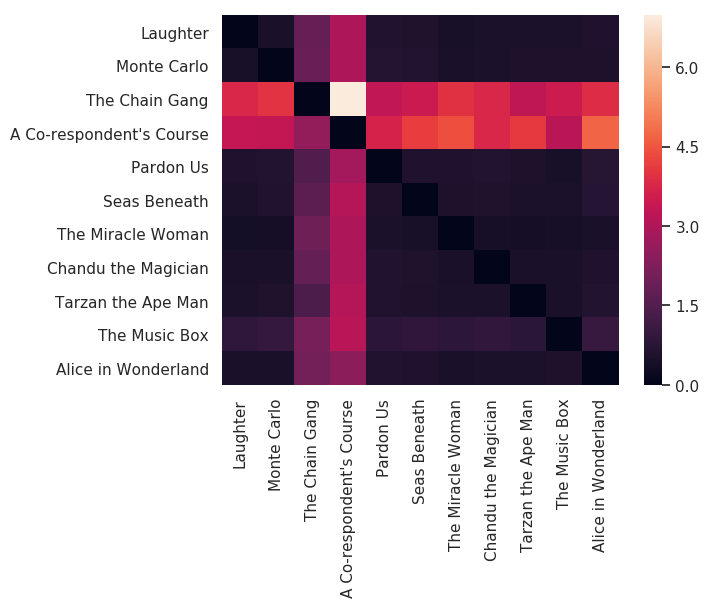

In [115]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()


To reveal more patterns, let's do a multidimensional scaling of the matrix.

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


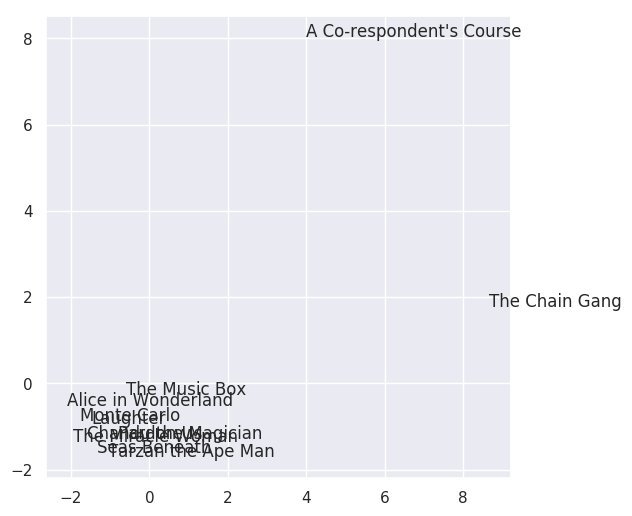

In [116]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

A co-respondent's course and The Chain Gang are away from the others - any guesses why?

We may just want to focus on the distrbution of stopwords or non-stopwords. Let's do the analysis again first for stopwords and then for non-stopwords.

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


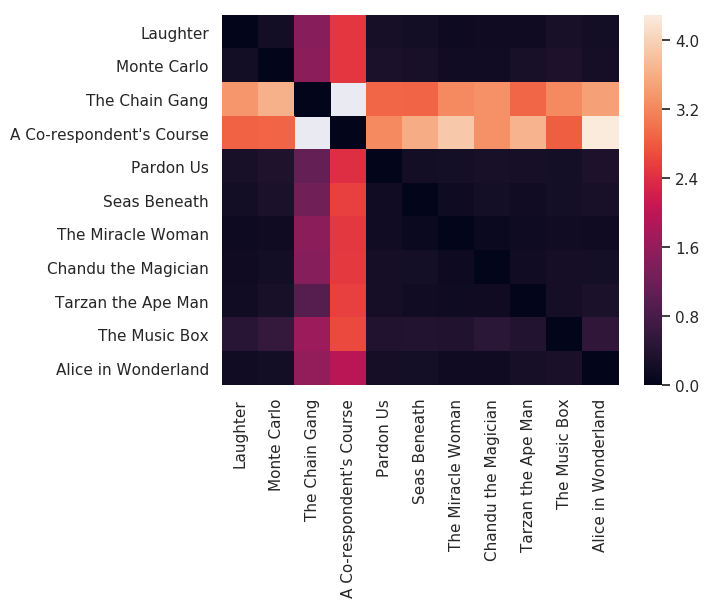

In [117]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

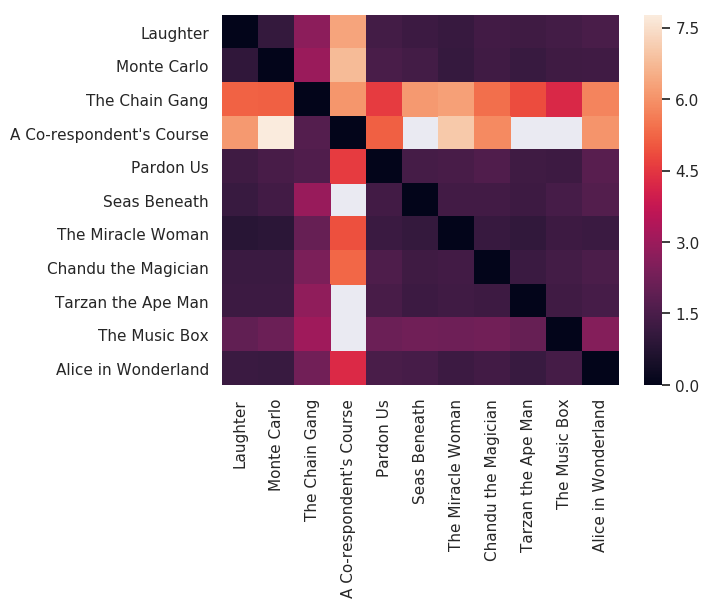

In [118]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

Now we compute the same for the assymmetric $\chi^2$ Divergence.

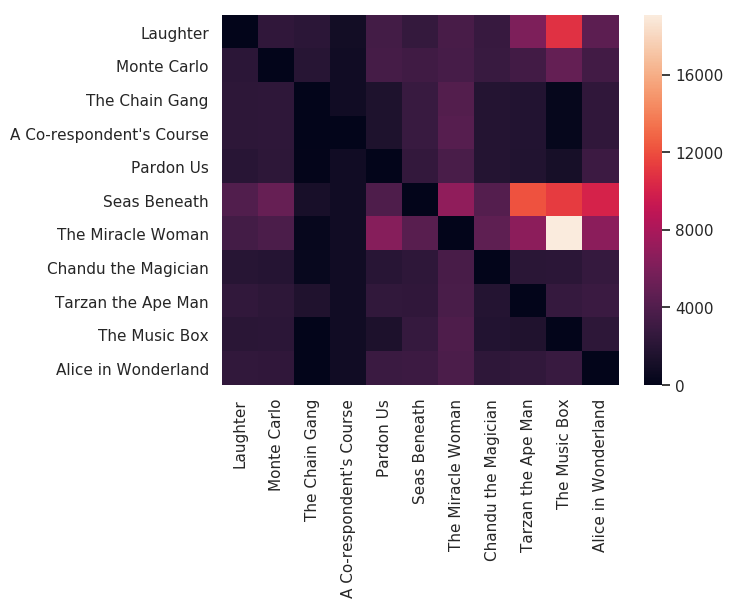

In [119]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

For the KS distance:

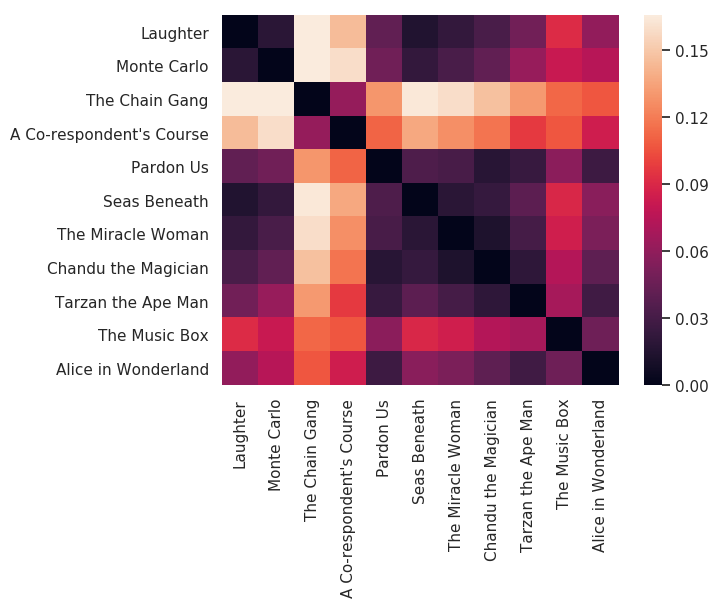

In [120]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

And finally for the Wasserstein or "earth mover's" Distance.

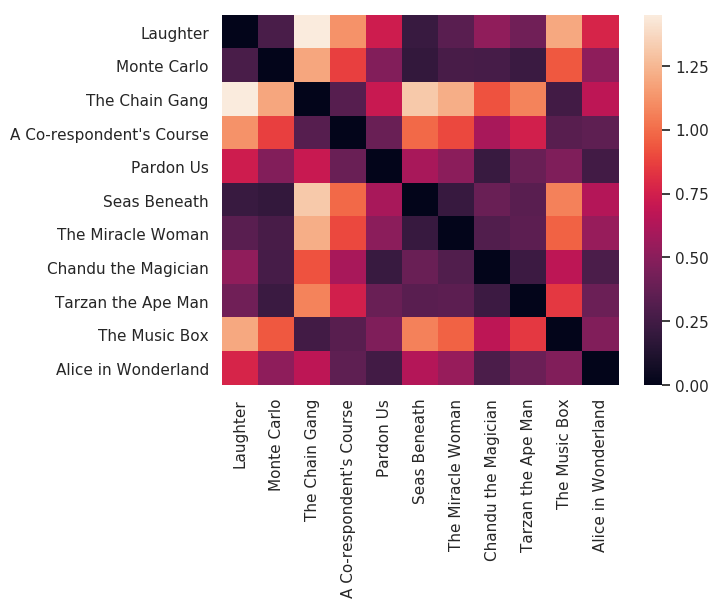

In [121]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

You can see that decade X is highly divergent and this makes reading the plot somewhat difficult. Let's fix this by taking the log of each cell, which will reduce the distance of decode X from other texts as an outlier.

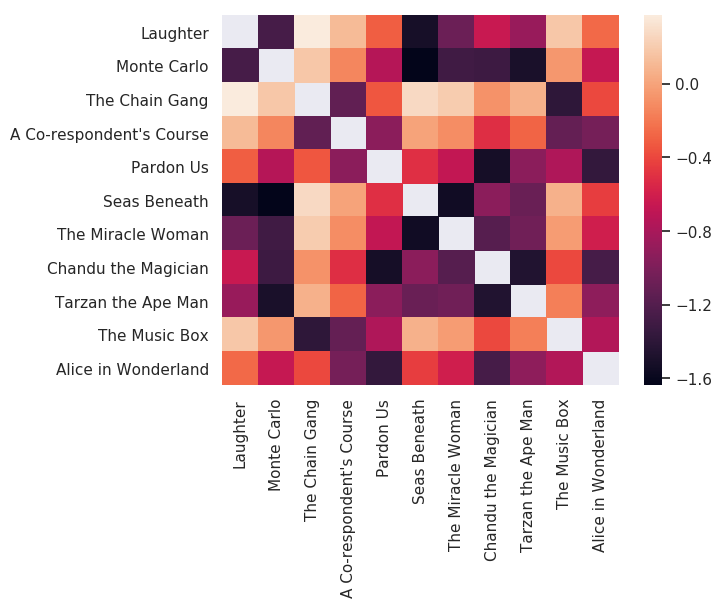

In [122]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

We only tried 11 movies, and from the same time period, so our signals might not be too interesting. What about different time periods?

An interesting experiment to maybe get some clearer signals: documents by decade in the Davies Corpus Of Historial American English (COHA) and see if we can detect patterns between them. 

If we want to rerun this on a new data set of our own composition, we can be a bit more efficient with our coding. Let's use the Shakespeare texts from last week as example: 

In [123]:
shakespeare_df = lucem_illud_2020.loadTextDirectory('../data/Shakespeare')

Now we stem and remove stopwords

In [124]:
shakespeare_df['tokenized_text'] = shakespeare_df['text'].apply(lambda x: word_tokenize(x))
shakespeare_df['normalized_tokens'] = shakespeare_df['tokenized_text'].apply(lambda x: normalizeTokens(x))

Create the corpus file and generate the heatmap:

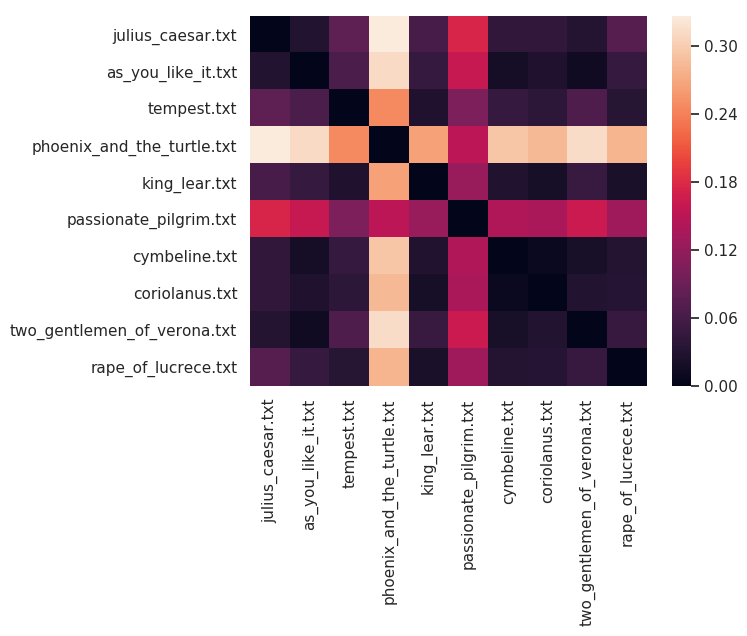

In [125]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 #The bigger this number the slower it will run, you can also try selecting your own plays
fileids_sp = list(shakespeare_df[:num_of_texts].index)
corpora_sp = list(shakespeare_df[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

What are "The Passionate Pilgrim" and "The Phoenix and the Turtle"? Little known poems by Shakespeare that are unsurprisingly hard to classify, as they are so different from everything else he wrote.

## <span style="color:red">*Exercise 6*</span>

<span style="color:red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better? 

<span style="color:red">**Stretch**: Calculate the <a "href=https://en.wikipedia.org/wiki/Jensen–Shannon_divergence" target="_blank">Jensen-Shannon Divergence</a> between your four corpora. What is the relationship between the KL and JS divergences?</span> 

For this exercise, I will be comparing the divergence measures of Tyrion's dialogue in the 8 seasons to see whether there is a substantial difference in the first 6 seasons and the last 2 seasons since it seems the quality of the last 2 seasons dropped significantly. 

In [129]:
tyrion_df.head(20)

,Release Date,Season,Episode,Episode Title,Name,Sentence,tokenized,normalized_tokens
145,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,Mmh. It is true what they say about the Northe...,"[Mmh, It, is, true, what, they, say, about, th...","[mmh, true, northern, girl]"
147,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,I did hear something about that.,"[I, did, hear, something, about, that]",[hear]
149,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,And the other brother?,"[And, the, other, brother]",[brother]
151,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,There's the pretty one. And there's the clever...,"[There, 's, the, pretty, one, And, there, 's, ...","[pretty, clever]"
153,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,I hear he hates that nickname.,"[I, hear, he, hates, that, nickname]","[hear, hate, nickname]"
155,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,Clever girl.,"[Clever, girl]","[clever, girl]"
157,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,Have you?,"[Have, you]",[]
158,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,The gods gave me one blessing.,"[The, gods, gave, me, one, blessing]","[god, give, blessing]"
161,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,Should I explain to you the meaning of a close...,"[Should, I, explain, to, you, the, meaning, of...","[explain, meaning, closed, door, whorehouse, b..."
163,2011-04-17,Season 1,Episode 1,Winter is Coming,tyrion lannister,"She has odd cravings, our sister.","[She, has, odd, cravings, our, sister]","[odd, craving, sister]"


In [145]:
# create a corpora that is a dictionary where the value of each key stores the sentences of Tyrion for each season.
# copora = {"season1": [], "season2": [], "season3": [], .... ,"season8":[]}
corpora = {"season1": [],
           "season2": [],
           "season3": [],
           "season4": [],
           "season5": [],
           "season6": [],
           "season7": [],
           "season8": []
}
for index, row in tyrion_df.iterrows():
    t = row['tokenized']
    r = row["Season"]
    if r == "Season 1":
        corpora["season1"].extend(t)
    if r == "Season 2":
        corpora["season2"].extend(t)
    if r == "Season 3":
        corpora["season3"].extend(t)
    if r == "Season 4":
        corpora["season4"].extend(t)
    if r == "Season 5":
        corpora["season5"].extend(t)
    if r == "Season 6":
        corpora["season6"].extend(t)
    if r == "Season 7":
        corpora["season7"].extend(t)
    if r == "Season 8":
        corpora["season8"].extend(t)
# l = [a, b, c] 
# l.append(d)
# [a, b, c, d]

# l = [a, b, c] 
# k = [d, e]
#l.extend(k)
# [a, b, c, d, e]

#l.append(k)
#[a, b, c, [d, e]]
print(corpora)

{'season1': ['Mmh', 'It', 'is', 'true', 'what', 'they', 'say', 'about', 'the', 'Northern', 'girls', 'I', 'did', 'hear', 'something', 'about', 'that', 'And', 'the', 'other', 'brother', 'There', "'s", 'the', 'pretty', 'one', 'And', 'there', "'s", 'the', 'clever', 'one', 'I', 'hear', 'he', 'hates', 'that', 'nickname', 'Clever', 'girl', 'Have', 'you', 'The', 'gods', 'gave', 'me', 'one', 'blessing', 'Should', 'I', 'explain', 'to', 'you', 'the', 'meaning', 'of', 'a', 'closed', 'door', 'in', 'a', 'whorehouse', 'brother', 'She', 'has', 'odd', 'cravings', 'our', 'sister', 'I', "'m", 'sorry', 'I', "'ve", 'begun', 'the', 'feast', 'a', 'bit', 'early', 'And', 'this', 'is', 'the', 'first', 'of', 'many', 'courses', 'Close', 'the', 'door', 'Your', 'uncle', "'s", 'in', 'the', 'Night', "'s", 'Watch', 'Preparing', 'for', 'a', 'night', 'with', 'your', 'family', 'I', "'ve", 'always', 'wanted', 'to', 'see', 'the', 'Wall', 'My', 'greatest', 'accomplishment', 'You', 'you', "'re", 'Ned', 'Stark', "'s", 'bastar

In [134]:
len(corpora)

8

In [146]:
# join each sentence in each season 
# for each value that corresponds to each key in the corpora dictionary, join the values; iterate each key's corresponding value, and join the sentences in each value
#for value in corpora.itervalues():
    #doc = nlp(' '.join(value))

corpora_s = []
corpora_nons = []
for key in corpora:
    season_sentences = corpora[key]
    s = []
    nons = []
    doc = nlp(' '.join(season_sentences))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)    

In [147]:
corpora_nons[0:10]

[['Mmh',
  'true',
  'Northern',
  'girls',
  'hear',
  'brother',
  'pretty',
  'clever',
  'hear',
  'hates',
  'nickname',
  'Clever',
  'girl',
  'gods',
  'gave',
  'blessing',
  'explain',
  'meaning',
  'closed',
  'door',
  'whorehouse',
  'brother',
  'odd',
  'cravings',
  'sister',
  "'",
  'm',
  'sorry',
  "'",
  've',
  'begun',
  'feast',
  'bit',
  'early',
  'courses',
  'Close',
  'door',
  'uncle',
  'Night',
  'Watch',
  'Preparing',
  'night',
  'family',
  "'",
  've',
  'wanted',
  'Wall',
  'greatest',
  'accomplishment',
  'Ned',
  'Stark',
  'bastard',
  'offend',
  'Sorry',
  'bastard',
  'Lady',
  'Stark',
  'mother',
  'Making',
  'bastard',
  'Let',
  'advice',
  'bastard',
  'forget',
  'rest',
  'world',
  'Wear',
  'like',
  'armor',
  'hurt',
  'dwarves',
  'bastards',
  'fathers',
  'eyes',
  'squirting',
  'end',
  'miracle',
  'greatest',
  'land',
  'spear',
  'misses',
  'Lord',
  'Lady',
  'Stark',
  'offer',
  'sympathies',
  'expected',
  'abse

In [148]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [149]:
seasonID = list(corpora.keys())

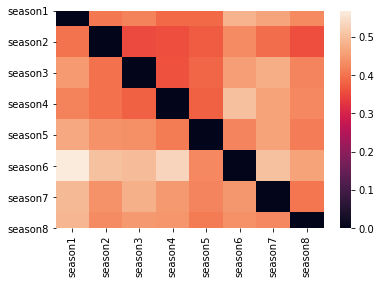

In [150]:
#heatmap with KL
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(corpora[p],corpora[q], difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = seasonID, index = seasonID)
ax = sns.heatmap(div)
plt.show()

By looking at the heatmap we can see that Tyrion's dialogue in season 6 is very different from his diaglues in season 1 and 4. Also, it seems Tyrion's dialogues starting from season 6 onward is more ore less divergent from the first 5 seasons. 

/Users/Tianyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


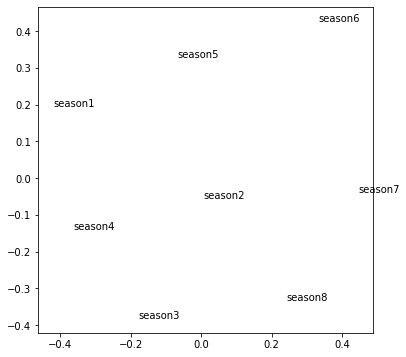

In [151]:
#Multidimensional Scaling Matrix
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(seasonID):
    ax.annotate(txt, (x[i],y[i]))

From the multidimensional scaling matrix, it seems all the dialogues of Tyrion in each season is very different. The heatmap seems to be a better indicator by comparison; or that the heatmap is able to convey a bit more information about divergence between the 8 seasons than the multidimensional scaling matrix.

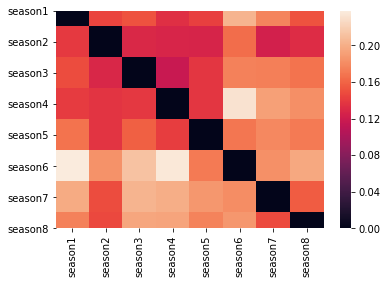

In [154]:
# distribution of stop words with KL
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = seasonID, index = seasonID)
ax = sns.heatmap(div)
plt.show()

The heatmap of stop words shows very clearly that Tyrion's dialogue in season 6 and season 4 are very dissimilar while his dialogues in the first 5 seasons show the most coherence. 

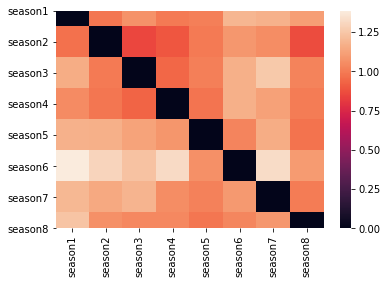

In [155]:
#distribution of non-stop words with KL
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = seasonID, index = seasonID)
ax = sns.heatmap(div)
plt.show()

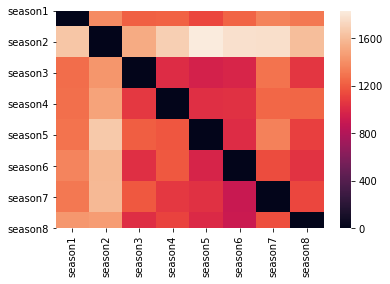

In [156]:
# distribution of non-stop words with chi square
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = seasonID, index = seasonID)
ax = sns.heatmap(div)
plt.show()

Interesingly, the heatmap using chi square divergence measure shows Tyrion's dialogues in season 2 seems to be the least similar with the rest of the seasons. 

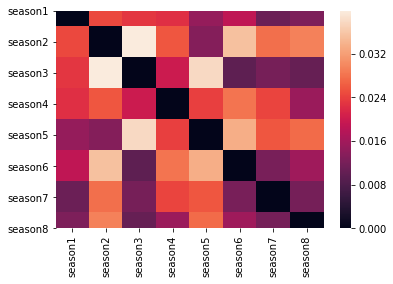

In [157]:
# distribution of non-stop words with KS
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = seasonID, index = seasonID)
ax = sns.heatmap(div)
plt.show()

KS divergence measure seems to indicate that Tyrion's dialogues in season 3 and season 2, as well as seaons 3 and season 5 are the least similar. 

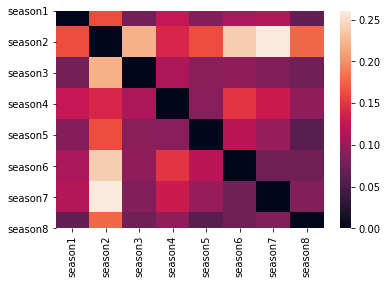

In [158]:
#distribution of non-stop words with Wasserstein's divergence measure
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = seasonID, index = seasonID)
ax = sns.heatmap(div)
plt.show()

This divergence measure shows that tyrion's conversations in season 2 and season 7 as well as season 2 and season 6 are the least similar.

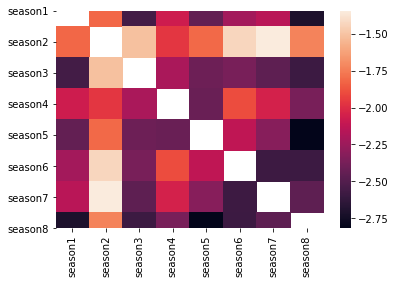

In [159]:
# Wasserstein's divergence measure applying log

ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

In [ ]:
#calcuate KL, X^2, KS, and Wasserstein distances between four corpora


# plot with heatmaps


#arway them in two dimensions with multidimensional scaling



In [ ]:
# what does this reveal about relations between the corpora


In [ ]:
# which analysis (and divergence and distribution) distinguishes the authors or documents better?

In [ ]:
# caluculate Jensen-Shannon Divergence between four corpora. What's the relationship between KL and JS divergences?

